**Soovitatav on käivitada kõik järgnev Google Colab'is. Teistel platvormidel ei saa garanteerida, et kõik toimib nii nagu peaks.**

In [1]:
# Colabi jaoks
from google.colab import drive
from google.colab import runtime
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Lõputöö/Bakalaureus')

Mounted at /content/drive


In [2]:
!python --version

Python 3.10.12


In [3]:
%pip install transformers
%pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [4]:
# Importimised
import time
import random
import transformers
import ast
import pickle
import re
import collections
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt

## Mudel

Selles peatükis koostatakse ja katsetatakse mudeleid, mis hakkavad ennustama muuttüüpe.

**Mudeli täpsuse parandamine**
* ~Leida keskmine sõnapikkus leksikonis~
* ~One-hot vektorid teha muuttüüpidest, et ei peaks eraldi mitme muuttüübiga klasse lisama. Mitme muuttüübi puhul ongi lihtsalt kaks väärtust 1ga, mitte üks.~

**Eksperimenteerimisplaan**

* ~Proovida ka sõnaliik (*või üldisemalt käändsõna, pöördsõna, muutumatu sõna*) mudelile ette anda (vektoriseerimine tuleb erinev sõna vektoriseerimisest)~
* Katsetada erinevate parameetritega mudeli treenimist (**`text_vect`** (vaata esimest punkti loendis), mudeli kihte jne.)
* ~Proovida erinevate suurustega andmehulkadel (kümnendik, viiendik, kolmandik jne.) (testhulk olgu fikseeritud kõigi katsete puhul)~
* ~Teha kindlaks *stratified sampling*'uga, et kõik muuttüübid oleksid esindatud treeninghulgas. Hiljem võib *Cross-validation*'it proovida~
* ~Salvestada mudeli tulemused .csv faili, luua mitte joondiagramm (X-epohh, Y-täpsus), vaid tulpdiagramm (X-parameetrite väärtused, Y-täpsus)~
* ~Startify train_test_split, kas suurem proportsioon muuttüübi esindavatest sõnadest läheb treeninghulka ja väiksem osa test&val hulka?~
* Kas saab sõnaplokke ja kõikide muuttüüpide esindamine hulkades kokku panna? (Edasiarenduse alla läheb)

* ~Sõnaliikide ja muuttüüpide kaupa uurida, kui hästi suudab mudel ennustada igat sõnaliiki testhulga~

* Uurida algvormide ja ülejäänud muutevormide ennustamise täpsus

**Viited mudeli ehitamisele (kust võtsin inspiratsioon?)**

**Suuremal korpusel täpsuse hindamine** [UD_Estonian-EDT](https://github.com/UniversalDependencies/UD_Estonian-EDT), [UD_Estonian-EWT (veebitekstid)](https://github.com/UniversalDependencies/UD_Estonian-EWT) *Veebitekstidelt saab teada, kas mudel suudab tuvastada õiget muuttüüpi hoolimata kirjavigadest. Samuti suuremal korpusel kindlustad sagedaste sõnade täpsust*
* Sõnade protsent, mis on ja pole Vabamorfi leksikonis
* Märgendada sõnadele juurde muuttüüp (korpusel pole muuttüüpe, need tuleb ise otsa märgendada, kasutades Vabamorfi põhisõnastiku)

---
* Rööptüüpe eristatav klassifitseerimine teeb mudeli täpsemaks, pole ainult põhimuuttüübid, millest teatud kahe tõesega tähistatakse rööptüüpi. See tähendab, et rööptüübile pole pandud 1 kahele põhitüübile, vaid see ongi eraldi klass
* Mida kõrgem numbervektori dimensioon (TextVectorization `max_length`), seda parem on täpsus, kuid alates 15-st taandub vahe märgatavalt. 5, 10 ja 15-25 on eristatavad üksteisest (pikkus vaheldub 5-se sammuga); ja seda kauem võtab treenimine aega
* Väiksem valimisuurus õpetab mudelit rohkem iga epohhiga. Valimisuurusega 64 tuli mudeli täpsus kehvem võrreldes 128-ga 20 epohhiga.
* Sõnaliigi lisamine (täpne vaste, mitte kolm klassi) tegi täpsuse natukene kehvemaks 5 epohhi peal




## LSTM

#### Andmete sisse lugemine ja analüüsimine

Selles peatükis loetakse sisse andmestik, mida kontrollitakse põgusalt üle.

In [5]:
df_algvormidega = pd.read_csv("andmed_algvormidega.csv", header=0, keep_default_na=False)

In [ ]:
display(df_algvormidega.head())
df_algvormidega.shape

,Sõnad,Sõnaliigid,Muuttüübid,Algvormid
0,ajalehed-ajakirjad,['S'],['0'],ajalehed-ajakirjad
1,ajalehtede-ajakirjade,['S'],['0'],ajalehed-ajakirjad
2,ajalehtesid-ajakirjasid,['S'],['0'],ajalehed-ajakirjad
3,ajalehti-ajakirju,['S'],['0'],ajalehed-ajakirjad
4,ajalehtedesse-ajakirjadesse,['S'],['0'],ajalehed-ajakirjad


(2240515, 4)

In [ ]:
# NaN või NA väärtused andmestikus
nan_values = df_algvormidega[df_algvormidega.isna().any(axis=1)]
print("Read NaN või NA väärtustega:")
display(nan_values)

Read NaN või NA väärtustega:


,Sõnad,Sõnaliigid,Muuttüübid,Algvormid


In [ ]:
df_algvormidega[df_algvormidega['Sõnaliigid'].apply(len) > 5]

,Sõnad,Sõnaliigid,Muuttüübid,Algvormid
1817,aabitsatarkus,"['S', 'S']","['11', '9']",aabitsatarkus
1818,aabitsatarkused,"['S', 'S']","['11', '9']",aabitsatarkus
1819,aabitsatarkuse,"['S', 'S']","['11', '9']",aabitsatarkus
1820,aabitsatarkuste,"['S', 'S']","['11', '9']",aabitsatarkus
1821,aabitsatarkust,"['S', 'S']","['11', '9']",aabitsatarkus
...,...,...,...,...
2240308,x-suurustena,"['S', 'S']","['11', '9']",x-suurus
2240309,x-suuruseta,"['S', 'S']","['11', '9']",x-suurus
2240310,x-suurusteta,"['S', 'S']","['11', '9']",x-suurus
2240311,x-suurusega,"['S', 'S']","['11', '9']",x-suurus


#### Statistika

Selles alampeatükis uuritakse andmestikku algvormide järgi sõnaliigiti ja muuttüübiti. Uuritakse, kui palju kirjeid on eemaldatud sünteesimise käigus.

Järgmine kood loeb kokku sõnaliike järgmiselt:
* kui sõnal on ainult üks sõnaliik, siis vastava sõnaliigi loenduri väärtus tõstetakse ühe võrra
* kui sõnal on mitu sõnaliiki, siis võetakse esimene sõnaliik ja selle loenduri väärtus tõstetakse ühe võrra

Lõpus väljastatakse sagedustabel.

In [6]:
# Sõnaliigi sagedused (ainult esimene sõnaliik mitme sõnaliigiga sõnast)

# Sõnaliigi kogumine algvormidest
sõnaliigid = list()
for sl in df_algvormidega['Sõnaliigid'][df_algvormidega['Sõnad'] == df_algvormidega['Algvormid']]:
  sl = re.sub(r"[\[\]']", "", sl).split(',')
  sõnaliigid.append(sl)

# Sagedustabel
sõnaliigid_freq = collections.defaultdict(lambda: 0)
for sõnaliik_list in sõnaliigid:
  if len(sõnaliik_list) == 1: # Ühe sõnaliigiga
    sõnaliigid_freq[sõnaliik_list[0]] += 1
  else: # Mitme sõnaliigiga
    sõnaliigid_freq[sõnaliik_list[0]] += 1

sõnaliigid_freq = sorted(sõnaliigid_freq.items(), key=lambda item: item[1], reverse=True) # Järjestamine

# Väljastamine
summa, summa_protsent = 0, 0
for item, freq in sõnaliigid_freq:
  print(f"{item}: {freq} ({round(freq / len(sõnaliigid) * 100, 3)}%)")
  summa += freq
  summa_protsent += freq / len(sõnaliigid) * 100
print(f"Summa: {summa} ({round(summa_protsent, 3)}%)")

S: 40394 (57.215%)
A: 10333 (14.636%)
V: 7875 (11.154%)
D: 6457 (9.146%)
H: 3639 (5.154%)
G: 584 (0.827%)
C: 414 (0.586%)
I: 336 (0.476%)
K: 204 (0.289%)
N: 102 (0.144%)
P: 100 (0.142%)
U: 70 (0.099%)
O: 48 (0.068%)
J: 23 (0.033%)
X: 21 (0.03%)
Summa: 70600 (100.0%)


Järgmine kood loeb kokku sõnaliike järgmiselt:
* kui sõnal on ainult üks sõnaliik, siis vastava sõnaliigi loenduri väärtus tõstetakse ühe võrra
* kui sõnal on mitu sõnaliiki, siis võetakse esimene sõnaliik ja selle loenduri väärtus tõstetakse ühe võrra

Lõpus väljastatakse sagedustabel.

Järgmine kood loeb kokku muuttüüpe järgmiselt:
* kui sõnal on ainult üks muuttüüp, siis vastava muuttüübi loendur tõstetakse ühe võrra
* kui sõnal on mitu muuttüüpi, siis koheldakse seda kui rööptüüpi ning selle muuttüübi loendur tõstetakse ühe võrra

Lisaks loendatakse muutumatuid sõnu ja muuttüüpi 0, mis on Vabamorfi loodud muuttüüp väga erandlike sõnade klassifitseerimiseks

Lõpus väljastatakse sagedustabel.

In [7]:
# Muuttüübi kogumine algvormidest
muuttüübid = list()
for mt in df_algvormidega['Muuttüübid'][df_algvormidega['Sõnad'] == df_algvormidega['Algvormid']]:
  mt = re.sub(r"[\[\]']", "", mt).split(',')
  muuttüübid.append(mt)

muuttüübid_freq = collections.defaultdict(lambda: 0)
muutumatud_freq = 0

# Sagedustabel
# Mitme muuttüübid omas kategoorias
for muuttüüp_list in muuttüübid:
  if len(muuttüüp_list) == 1:
    muuttüübid_freq[str(muuttüüp_list[0])] += 1
  else:
    mttps = ""
    for i in range(len(muuttüüp_list)):
      item = muuttüüp_list[i]
      if i == len(muuttüüp_list) - 1:
        mttps += item
      else:
        mttps += item + ","
    muuttüübid_freq[mttps] += 1

muuttüübid_freq = sorted(muuttüübid_freq.items(), key=lambda item: item[1], reverse=True) # Järjestamine

# Väljastamine
käändsõnad_freq = {}
pöördsõnad_freq = {}

for tüüp, freq in muuttüübid_freq:
  el = tüüp.split(",")
  #print(el, freq)
  if el[0] == '-':
    muutumatud_freq = freq
  elif int(el[0]) == 0:
    tundmatu_freq = freq
  elif int(el[0]) <= 26:
    käändsõnad_freq[tüüp] = freq
  else:
    pöördsõnad_freq[tüüp] = freq

käändsõnad_sum = 0
pöördsõnad_sum = 0
summa_protsent = 0

print("Käändsõnad")
for item, freq in käändsõnad_freq.items():
  print(f"{item}: {freq} ({round(freq / len(muuttüübid) * 100, 4)}%)")
  käändsõnad_sum += freq
  summa_protsent += freq / len(muuttüübid) * 100
print(f"Kokku: {käändsõnad_sum} ({round(summa_protsent, 4)}%)\n")

summa_protsent = 0

print("Pöördsõnad")
for item, freq in pöördsõnad_freq.items():
  print(f"{item}: {freq} ({round(freq / len(muuttüübid) * 100, 4)}%)")
  pöördsõnad_sum += freq
  summa_protsent += freq / len(muuttüübid) * 100
print(f"Kokku: {pöördsõnad_sum} ({round(summa_protsent, 4)}%)\n")
print(f"Muuttüüp 0: {tundmatu_freq} ({round(tundmatu_freq / len(muuttüübid) * 100, 4)}%)")
print(f"Muutumatud sõnad: {muutumatud_freq} ({round(muutumatud_freq / len(muuttüübid) * 100, 4)}%)")
print(f"\nKokku: {käändsõnad_sum + pöördsõnad_sum + tundmatu_freq + muutumatud_freq} ({round((käändsõnad_sum + pöördsõnad_sum + tundmatu_freq + muutumatud_freq) / len(muuttüübid) * 100, 4)}%)")

Käändsõnad
22: 13708 (19.4164%)
2: 11219 (15.8909%)
1: 4629 (6.5567%)
12: 4281 (6.0637%)
11: 3889 (5.5085%)
16: 2685 (3.8031%)
11, 9: 2462 (3.4873%)
17: 1721 (2.4377%)
25: 1514 (2.1445%)
26: 1240 (1.7564%)
10: 1085 (1.5368%)
6: 1055 (1.4943%)
12, 10: 902 (1.2776%)
9: 582 (0.8244%)
19: 545 (0.772%)
13: 531 (0.7521%)
7: 453 (0.6416%)
24: 397 (0.5623%)
18: 393 (0.5567%)
5: 226 (0.3201%)
23, 22: 199 (0.2819%)
19, 2: 187 (0.2649%)
14: 184 (0.2606%)
20: 107 (0.1516%)
4: 105 (0.1487%)
21: 99 (0.1402%)
8: 79 (0.1119%)
15: 70 (0.0992%)
3, 5: 22 (0.0312%)
23: 19 (0.0269%)
10, 12: 14 (0.0198%)
3: 11 (0.0156%)
5, 7: 5 (0.0071%)
Kokku: 54618 (77.3626%)

Pöördsõnad
27: 5029 (7.1232%)
28: 1957 (2.772%)
29: 518 (0.7337%)
30: 186 (0.2635%)
34: 70 (0.0992%)
31, 27: 37 (0.0524%)
36: 16 (0.0227%)
28, 27: 14 (0.0198%)
35: 11 (0.0156%)
38: 11 (0.0156%)
32: 10 (0.0142%)
33: 7 (0.0099%)
37: 6 (0.0085%)
Kokku: 7872 (11.1501%)

Muuttüüp 0: 52 (0.0737%)
Muutumatud sõnad: 8058 (11.4136%)

Kokku: 70600 (100.0%)


In [ ]:
näited = df_algvormidega[df_algvormidega['Sõnad'] == df_algvormidega['Algvormid']]
näited = näited[näited['Muuttüübid'] == "['3']"]
näited = pd.unique(näited['Algvormid'])
display(näited)

array(['aher', 'ainus', 'ihnus', 'kõneaher', 'manner', 'mõtteaher',
       'sõnaaher', 'tanner', 'vaher', 'veeaher', 'üksainus'], dtype=object)

In [100]:
display(df_algvormidega[df_algvormidega['Algvormid'] == 'ainus'])

,Sõnad,Sõnaliigid,Muuttüübid,Algvormid
25721,ainus,['S'],['3'],ainus
25722,ainus,['S'],['5'],ainus
25723,ainsad,"['S', 'S']","['3', '5']",ainus
25724,ainsa,['S'],['3'],ainus
25725,ainsa,['S'],['5'],ainus
25726,ainsate,"['S', 'S']","['3', '5']",ainus
25727,ainsat,"['S', 'S']","['3', '5']",ainus
25728,ainust,"['S', 'S']","['3', '5']",ainus
25729,ainsaid,"['S', 'S']","['3', '5']",ainus
25730,ainsasse,['S'],['3'],ainus


Järgmise koodiga analüüsitakse sõnu, täpsemalt keskmine sõna pikkus ja pikim sõna andmestikus.

In [ ]:
# Sõnade keskmine pikkus andmestikus
tähtede_arv = 0
sõnad = df_algvormidega['Sõnad']
sõnade_arv = len(sõnad)

for sõna in sõnad:
  tähtede_arv += len(sõna)

print(f"Keskmine sõna pikkus andmestikus: {round(tähtede_arv / sõnade_arv, 3)}")


# Pikim sõna
max_tähtede_arv = 0
pikim_sõna = ""

for sõna in sõnad:
  if len(sõna) > max_tähtede_arv:
    pikim_sõna = sõna
    max_tähtede_arv = len(sõna)

print(f"Pikim sõna andmestikus: {pikim_sõna} ({max_tähtede_arv} tähte)")

Keskmine sõna pikkus andmestikus: 11.65
Pikim sõna andmestikus: ratsionaliseerimisettepanekutesse (33 tähte)


#### Andmete grupeerimine algvormidega (edasiarenduseks)

Selles peatükis on katsetatud andmete grupeerimist algvormide kaupa nii, et ühes grupis on sõna algvorm koos oma muutevormidega.

In [ ]:
sõna_grupid = df_algvormidega.groupby('Algvormid')
sõna_grupid_võtmed = list(sõna_grupid.groups.keys())
random.shuffle(sõna_grupid_võtmed)

In [ ]:
#sõna_grupid.groups.keys()

In [ ]:
sõna_grupid.get_group(('armas'))

,Sõnad,Sõnaliigid,Muuttüübid,Algvormid
83735,armas,"['A', 'A']","['3', '5']",armas
83736,armsad,"['A', 'A']","['3', '5']",armas
83737,armsa,"['A', 'A']","['3', '5']",armas
83738,armsate,"['A', 'A']","['3', '5']",armas
83739,armast,['A'],['5'],armas
83740,armsat,['A'],['3'],armas
83741,armsaid,"['A', 'A']","['3', '5']",armas
83742,armsasse,"['A', 'A']","['3', '5']",armas
83743,armsaisse,"['A', 'A']","['3', '5']",armas
83744,armsatesse,"['A', 'A']","['3', '5']",armas


In [ ]:
print(f"Võtmete arv: {len(sõna_grupid_võtmed)}")

Võtmete arv: 70215


In [ ]:
grupid_muuttüüpidega = []
for key, group in sõna_grupid:
  unique_mt = tuple(group['Muuttüübid'].unique())
  grupid_muuttüüpidega.append([key, unique_mt]) # Sulgude ja lõpukoma eemaldamine

grupid_mt_df = pd.DataFrame(grupid_muuttüüpidega, columns=['Algvormid', 'Muuttüübid'])

In [ ]:
display(grupid_mt_df)

,Algvormid,Muuttüübid
0,1/16-finaal,"(['22'],)"
1,1/2-finaal,"(['22'],)"
2,1/4-finaal,"(['22'],)"
3,1/8-finaal,"(['22'],)"
4,Aabel,"(['2'],)"
...,...,...
70210,žoržett,"(['22'],)"
70211,žurnaal,"(['22'],)"
70212,žurnalist,"(['22'],)"
70213,žurnalistika,"(['1'],)"


In [ ]:
grupid_mt_df[grupid_mt_df['Algvormid'] == 'armas']

,Algvormid,Muuttüübid
5891,armas,"(['3', '5'], ['5'], ['3'])"


### Parima täpsusega mudeli leidmine

Selles peatükis katsetakse erinevate parameetritega mudeleid, et lõpuks leida mudel, mis suudab kõige täpsemini ennustada sõnale muuttüüpi.

#### Defineeritud funktsioonid

Järgmine kood on sõnastik, mis teisendab sõnaliigid üldisemateks variantideks
* käändsõnad: 'n';
* pöördsõnad: 'v';
* muutumatud sõnad (ja muud): 'u'.

In [ ]:
pos_to_group = {
        "['A']": 'n',  # omadussõna - algvõrre (adjektiiv - positiiv), nii käänduvad kui käändumatud, nt kallis või eht, Adjective
        "['C']": 'n',  # omadussõna - keskvõrre (adjektiiv - komparatiiv), nt laiem, Comparative adjective
        "['D']": 'u',  # määrsõna (adverb), nt kõrvuti, Adverb
        "['G']": 'u',  # genitiivatribuut (käändumatu omadussõna), nt balti, Genitive attribute
        "['H']": 'n',  # pärisnimi, nt Edgar, Proper noun
        "['I']": 'u',  # hüüdsõna (interjektsioon), nt tere, Interjection
        "['J']": 'u',  # sidesõna (konjunktsioon), nt ja, Conjunction
        "['K']": 'u',  # kaassõna (pre/postpositsioon), nt kaudu, Pre/postposition
        "['N']": 'n',  # põhiarvsõna (kardinaalnumeraal), nt kaks, Cardinal numeral
        "['O']": 'n',  # järgarvsõna (ordinaalnumeraal), nt teine, Ordinal numeral
        "['P']": 'n',  # asesõna (pronoomen), nt see, Pronoun
        "['S']": 'n',  # nimisõna (substantiiv), nt asi, Noun
        "['U']": 'n',  # omadussõna - ülivõrre (adjektiiv - superlatiiv), nt pikim, Superlative adjective
        "['V']": 'v',  # tegusõna (verb), nt lugema, Verb
        "['X']": 'u',  # verbi juurde kuuluv sõna, millel eraldi sõnaliigi tähistus puudub, nt plehku, Adverb-like word used solely with a certain verb
        "['Y']": 'n',  # lühend, nt USA, Abbreviation or acronym
        "['Z']": 'u',  # lausemärk, nt -, /, ..., Punctuation
        # Siit alates lisaks statistikast leitud read
        "['S', 'S']": 'n',
        "['A', 'A']": 'n',
        "['S', 'I']": 'n',
        "['V', 'V']": 'v',
        "['D', 'K']": 'u',
        "['H', 'H']": 'n',
        "['P', 'P']": 'n',
        "['S', 'A']": 'n',
        "['K', 'D']": 'u',
        "['A', 'S']": 'n',
    }

Järgmine funktsioon kogub X andmed (sõnad), millelt mudel peab hakkama ennustama muuttüüpi.

In [ ]:
def get_X(max_pikkus):
  global df_algvormidega, sõna_grupid_võtmed
  print("Kogun andmeid X")
  #treening_võtmed, test_võtmed = sk.model_selection.train_test_split(sõna_grupid_võtmed, test_size=0.2, random_state=42)
  #test_võtmed, valideerimis_võtmed = sk.model_selection.train_test_split(test_võtmed, test_size=0.5, random_state=42)
  X = df_algvormidega['Sõnad'].apply(lambda x: x[-max_pikkus:])
  #y = [muuttüüp for muuttüüp in df_algvormidega['Muuttüübid']]
  print("X andmehulk käes\n")
  return X

Järgmine funktsioon kogub y andmed (muuttüübid), mida mudel peab hakkama ennustama.

In [ ]:
def get_y():
  global df_algvormidega
  print("y andmete kogumine")
  y = df_algvormidega['Muuttüübid'].apply(lambda x: [x]) # lambda x: [x] arvestab rööptüüpidega
  print("y andmed kogutud\n")
  mlb_w = sk.preprocessing.MultiLabelBinarizer()
  print("MultiLabelBinarizer kohandamine")
  mlb_w.fit(y)
  print("MultiLabelBinarizer kohandatud\n")
  return y, mlb_w

Järgmine funktsioon kogub sõnaliike (kuulub X andmete hulka), millele lisaks saab mudel tugineda muuttüübi ennustamisel.

In [ ]:
def get_sõnaliigid():
  global df_algvormidega
  print("X andmete (sõnaliigid) kogumine")
  X_s = df_algvormidega['Sõnaliigid'].apply(lambda x: [x])
  print("X andmed (sõnaliigid) kogutud\n")
  mlb_s = sk.preprocessing.MultiLabelBinarizer()
  print("MultiLabelBinarizer kohandamine")
  mlb_s.fit(X_s)
  print("MultiLabelBinarizer kohandatud\n")
  return mlb_s

Järgmine funktsioon kogub sõnaliike üldisemas võtmes. Teisisõnu grupeeritakse kõik sõnaliigid kolme klassi: käändsõnad, pöördsõnad ja muutumatud sõnad.

In [ ]:
def get_sõnaliigid_üldisem():
  global df_algvormidega, pos_to_group
  print("X andmete (sõnaliigid) kogumine ja ümbertöötlemine")
  X_s_grouped = df_algvormidega['Sõnaliigid'].apply(lambda x: pos_to_group.get(x, 'u'))
  print("X andmed (sõnaliigid) kogutud ja ümbertöödeldud")
  mlb_s = sk.preprocessing.MultiLabelBinarizer()
  print("MultiLabelBinarizer kohandamine")
  mlb_s.fit(X_s_grouped)
  print("MultiLabelBinarizer kohandatud\n")
  X_s_grouped_df = pd.DataFrame(X_s_grouped, columns=['Sõnaliigid'])
  X_s_grouped_df = X_s_grouped_df.rename(columns={'Sõnaliigid': 'Üldsõnaliigid'})
  return X_s_grouped_df, mlb_s

Järgmine funktsioon tagastab kohandatud `TextVectorization` kihi. Kui varasemalt on teatud parameetritega `TextVectorization` kiht kohandatud, siis tagastatakse see. Vastasel korral luuakse uus kiht, kohandatakse üle andmestiku X ja salvestatakse uus `TextVectorization` kiht.

In [ ]:
def tekst_vect_failid(max_pikkus, X):
  # ChatGPT abi kasutatud
  tekst_vect = tf.keras.layers.TextVectorization(split="character",
                                                 output_mode="int",
                                                 output_sequence_length=max_pikkus) #,standardize='strip_punctuation')
  print("Olemasoleva TextVectorization otsimine")

  # Kaust, kuhu on kogutud kõik TextVectorization'id
  kaust = "./TextVectorizations/"

  # Tekst_vect failide asukohad
  architecture_file = kaust + "text_vectorization_len_" + str(max_pikkus) + "_model_architecture.pkl"
  vocab_file = kaust + "text_vectorization_len_" + str(max_pikkus) + "_vocab.pkl"

  # Kui on olemas failid, siis loe sisse
  if os.path.exists(architecture_file) and os.path.exists(vocab_file):
    print("Olemasolev TextVectorization leitud")
    with open(architecture_file, "rb") as f:
        model_config = pickle.load(f)
    with open(vocab_file, "rb") as f:
        vocab = pickle.load(f)

    tekst_vect = tf.keras.layers.TextVectorization.from_config(model_config)
    tekst_vect.set_vocabulary(vocab)
  else:
    print("Ei leidnud olemasolevat TextVectorization. Uue kohandamine ja salvestamine")
    # Kohanda
    tekst_vect.adapt(X)
    # Tekst_vect arhitektuuri salvestamine
    with open(architecture_file, "wb") as f:
        pickle.dump(tekst_vect.get_config(), f)

    # ja selle sõnastiku salvestamine
    vocab = tekst_vect.get_vocabulary()
    with open(vocab_file, "wb") as f:
        pickle.dump(vocab, f)

  print("TextVectorization käes/kohandatud\n")
  return tekst_vect

Järgmine funktsioon väljastab, kuidas on X ja y andmed teisendatud (enne ja pärast teisendamist) ning kohandatud klassifitseerija `mlb_w` (palju klasse ja mis klassid).

In [ ]:
def print_lõppseis(X, X_train,
                   X_train_vecs, X_test_vecs, X_val_vecs,
                   y, y_train,
                   y_train_vecs, y_test_vecs, y_val_vecs,
                   mlb_w):
  print("\033[1mX teisendus\033[0m\n")
  print(f"Kokku: {len(X)}")
  print(f"Treeninghulk: {len(X_train_vecs)}")
  print(f"Testhulk: {len(X_test_vecs)}")
  print(f"Valideerimishulk: {len(X_val_vecs)}")
  display(X_train[:5])
  print("X teisendatud")
  display(X_train_vecs[:5])
  print()
  print("\033[1my teisendus\033[0m\n")
  print(f"Kokku: {len(y)}")
  print(f"Treeninghulk: {len(y_train_vecs)}")
  print(f"Testhulk: {len(y_test_vecs)}")
  print(f"Valideerimishulk: {len(y_val_vecs)}")
  print("y teisendamata")
  display(y_train[:5])
  print("y teisendatud")
  display(y_train_vecs[:5])
  print(f"Muuttüüpide klassid: {mlb_w.classes_}")
  print(f"{len(mlb_w.classes_)} klassi\n")

Järgmine funktsioon on eelmise täiend. Tagastatakse lisaks kohandatud sõnaliigi klassifitseerija klassid ning treening-, test-, ja valideerimishulkade suurused.

In [ ]:
def print_lõppseis_sõnaliigiga(X, X_train,
                               X_train_w_vecs, X_test_w_vecs, X_val_w_vecs,
                               X_train_s_vecs, X_test_s_vecs, X_val_s_vecs,
                               y, y_train,
                               y_train_vecs, y_test_vecs, y_val_vecs,
                               mlb_w, mlb_s):
  print("\033[1mX teisendus\033[0m\n")
  print(f"Kokku: {len(X)}")
  print(f"Treeninghulk: {len(X_train_w_vecs)} : {len(X_train_s_vecs)}")
  print(f"Testhulk: {len(X_test_w_vecs)} : {len(X_test_s_vecs)}")
  print(f"Valideerimishulk: {len(X_val_w_vecs)} : {len(X_val_s_vecs)}")
  print("X teisendamta")
  display(X_train[:5])
  print("X teisendatud")
  display(X_train_w_vecs[:5])
  display(X_train_s_vecs[:5])
  print()
  print("\033[1my teisendus\033[0m\n")
  print(f"Kokku: {len(y)}")
  print(f"Treeninghulk: {len(y_train_vecs)}")
  print(f"Testhulk: {len(y_test_vecs)}")
  print(f"Valideerimishulk: {len(y_val_vecs)}")
  print("y teisendamata")
  display(y_train[:5])
  print("y teisendatud")
  display(y_train_vecs[:5])
  print(f"Muuttüüpide klassid: {mlb_w.classes_}")
  print(f"{len(mlb_w.classes_)} klassi\n")
  print(f"Sõnaliikide klassid: {mlb_s.classes_}")
  print(f"{len(mlb_s.classes_)} klassi\n")

Järgmine funktsioon ehitab üles mudeli, mille sisendiks on ainult sõna.

In [ ]:
def mudel_init(max_pikkus, mlb_w, tekst_vect, dropout):
  print("Mudeli ülesehitamine")
  tf.random.set_seed(7)

  sõnavara_suurus = tekst_vect.vocabulary_size() # Sõnastiku suurus
  output_dim = len(mlb_w.classes_) # Ennustatavate klasside arv

  mudel = tf.keras.models.Sequential()

  # Embedding
  mudel.add(tf.keras.layers.Embedding(input_dim=sõnavara_suurus, output_dim=output_dim, input_length=max_pikkus, mask_zero=True))

  # LSTM
  mudel.add(tf.keras.layers.LSTM(160, return_sequences=False))

  # Dropout
  mudel.add(tf.keras.layers.Dropout(float(dropout)))

  # Dense
  mudel.add(tf.keras.layers.Dense(len(mlb_w.classes_), activation='softmax'))

  mudel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

  # Mudeli kuju
  mudel.summary()
  tf.keras.utils.plot_model(mudel,
                            to_file=f"model_max_pikkus_{max_pikkus}.png",
                            show_shapes=True,
                            show_dtype=True,
                            show_layer_names=True,
                            show_trainable=True
                            )

  earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
  callbacks = [earlystopping]
  print("Mudel ülesehitatud\n")
  return mudel, callbacks

Järgmine funktsioon ehitab üles mudeli, mille sisendiks on sõna ja sõnaliik.

In [ ]:
def mudel_init_sõnaliigiga(max_pikkus, mlb_w, mlb_s, tekst_vect, dropout):
  # https://www.tensorflow.org/guide/keras/functional_api#models_with_multiple_inputs_and_outputs
  print("Mudeli ülesehitamine")
  tf.random.set_seed(7)

  # Parameetrid
  sõnavara_suurus = tekst_vect.vocabulary_size() # Sõnastiku suurus
  output_dim_w = len(mlb_w.classes_) # Ennustatavate klasside arv
  output_dim_s = len(mlb_s.classes_) # Sõnaliikide klasside arv

  # Sisendid
  sõna_input = tf.keras.layers.Input(shape=(max_pikkus,), name='sõna')
  sõnaliik_input = tf.keras.layers.Input(shape=(output_dim_s,), name='sõnaliik')

  # Embeddings
  sõna_features = tf.keras.layers.Embedding(sõnavara_suurus, output_dim_w, input_length=max_pikkus)(sõna_input)
  sõnaliik_features  = tf.keras.layers.Embedding(output_dim_s, output_dim_w, input_length=output_dim_s)(sõnaliik_input)

  # LSTMs
  sõna_features = tf.keras.layers.LSTM(256)(sõna_features)
  sõnaliik_features = tf.keras.layers.LSTM(256)(sõnaliik_features)

  # Dropout
  sõna_features = tf.keras.layers.Dropout(float(dropout))(sõna_features)
  sõnaliik_features = tf.keras.layers.Dropout(float(dropout))(sõnaliik_features)

  # Merge
  x = tf.keras.layers.concatenate([sõna_features, sõnaliik_features])

  # Dense
  muuttüüp_pred = tf.keras.layers.Dense(len(mlb_w.classes_), activation='softmax')(x)

  mudel = tf.keras.Model(
      inputs=[sõna_input, sõnaliik_input],
      outputs=[muuttüüp_pred]
  )

  mudel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

  # Mudeli kuju
  mudel.summary()
  tf.keras.utils.plot_model(mudel,
                            to_file=f"model_sõnaliigiga_max_pikkus_{max_pikkus}.png",
                            show_shapes=True,
                            show_dtype=True,
                            show_layer_names=True,
                            show_trainable=True
                            )


  earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
  callbacks = [earlystopping]
  print("Mudel ülesehitatud\n")
  return mudel, callbacks

Järgmine funktsioon hindab treenitud mudelit testandmetega.

In [ ]:
def test_tulemused(X_test_vecs, y_test, mudel):
  loss, accuracy = mudel.evaluate(X_test_vecs, y_test)
  print(f"Test kadu: {loss}")
  print(f"Test täpsus: {accuracy}")
  ennustused = mudel.predict(X_test_vecs)

Järgmine funktsioon salvestab ning väljastab joondiagrammi, mille lähteandmeteks on mudeli tulemused (erinevad meetrikud).

In [ ]:
def näita_tulemusi_joon(tulemused, max_pikkused, batch_size):
  print("Tulemuste väljastamine\n")
  fig = plt.figure(figsize=(10, 6))
  for i, tulemus in enumerate(tulemused):
    plt.plot(tulemus['accuracy'], label=f"max_pikkus={max_pikkused[i]} (Train)")
    plt.plot(tulemus['val_accuracy'], label=f"max_pikkus={max_pikkused[i]} (Val)")
  plt.title('Mudeli täpsus')
  plt.xlabel('Epohh')
  plt.ylabel('Täpsus')
  plt.legend()
  plt.show()
  fig.savefig(f"model_batchsize_{str(batch_size)}.pdf", format='pdf')

Järgmine funktsioon salvestab ning väljastab tulpdiagrammi, mille lähteandmeteks on mudeli tulemused (erinevad meetrikud).

In [ ]:
def näita_tulemusi_tulp(tulemused, max_pikkused, batch_sizes, epochs, mudel, dropout):
  # https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
  print("Väljastan tulemused\n")
  num_max_pikkused = len(max_pikkused)

  num_batch_sizes = len(batch_sizes)
  bar_width = 0.25
  index = np.arange(num_max_pikkused)
  fig, ax = plt.subplots(figsize=(12, 8))

  if num_max_pikkused == 1 and num_batch_sizes == 1:
    bar_width = 0.75
    index = np.arange(num_batch_sizes)
    output_name = f"max_pikkus_{max_pikkused[0]}_batch_size_{batch_sizes[0]}"
    val_täpsused = [tulemus['val_accuracy'][-1] for tulemus in tulemused]
    rects = ax.bar(index, val_täpsused, bar_width, label=f"Vektori suurus = {max_pikkused[0]}")
    ax.set_xticks(index)
    ax.set_xticklabels(batch_sizes)
    ax.set_xlabel('Valimi suurus', fontsize=14)
    ax.bar_label(rects, padding=3, fmt='%.3f')

  elif num_max_pikkused == 1:
    bar_width = 0.75
    index = np.arange(num_batch_sizes)
    output_name = f"max_pikkus_{max_pikkused[0]}"
    val_täpsused = [tulemus['val_accuracy'][-1] for tulemus in tulemused]
    rects = ax.bar(index, val_täpsused, bar_width, label=f"Vektori suurus = {max_pikkused[0]}")
    ax.set_xticks(index)
    ax.set_xticklabels(batch_sizes)
    ax.set_xlabel('Valimite suurused', fontsize=14)
    ax.bar_label(rects, padding=3, fmt='%.3f')

  elif num_batch_sizes == 1:
    bar_width = 0.75
    index = np.arange(num_max_pikkused)
    output_name = f"batch_size_{batch_sizes[0]}"
    val_täpsused = [tulemus['val_accuracy'][-1] for tulemus in tulemused]
    rects = ax.bar(index, val_täpsused, bar_width, label=f"Valimi suurus = {batch_sizes[0]}")
    ax.set_xticks(index)
    ax.set_xticklabels(max_pikkused)
    ax.set_xlabel('Vektori suurus', fontsize=14)
    ax.bar_label(rects, padding=3, fmt='%.3f')

  else:
    bar_width = round(0.75/num_batch_sizes, 5)
    index = np.arange(num_max_pikkused)
    output_name = f"batch_sizes{batch_sizes[0]}-{batch_sizes[-1]}_max_pikkused{max_pikkused[0]}-{max_pikkused[-1]}"

    for i in range(num_max_pikkused):
      val_täpsused = [tulemus['val_accuracy'][-1] for tulemus in tulemused[i::num_max_pikkused]]
      rects = ax.bar(index + i * bar_width, val_täpsused, bar_width, label=f"Vektori suurus = {max_pikkused[i]}")

    ax.set_xticks(index + (bar_width * (num_max_pikkused - 1)) / 2)
    ax.set_xticklabels(max_pikkused, fontsize=12)
    ax.set_xlabel('Vektori suurus', fontsize=14)
    ax.bar_label(rects, padding=3, fmt='%.3f')

  ax.tick_params(axis='y', labelsize=12)
  ax.set_title(f"Viimase epohhi ({epochs}.) valideerimishulga täpsus", fontsize=16)
  ax.set_ylabel("Täpsus", fontsize=14)
  ax.grid(axis='y', linestyle='--')

  plt.legend(loc='upper right', bbox_to_anchor=(1, 1.06))
  plt.show()
  fig.savefig(f"{mudel}_dropout_{dropout}_{output_name}_bar_chart.pdf", format='pdf')

Järgmine funktsioon salvestab tulemused (erinevad meetrikud) faili.

In [ ]:
def save_tulemused(tulemused, max_pikkused, batch_sizes, epochs, mudel, dropout):
  print("Tulemuste salvestamine numpy'iga")
  if len(max_pikkused) == 1 and len(batch_sizes) == 1:
    file_path = f"history_{mudel}_dropout_{dropout}_max_pikkus_{max_pikkused[0]}_batch_size_{batch_sizes[0]}_epochs_{epochs}"
  elif len(max_pikkused) == 1:
    file_path = f"history_{mudel}_dropout_{dropout}_max_pikkus_{max_pikkused[0]}_batch_sizes_{batch_sizes[0]}-{batch_sizes[-1]}_epochs_{epochs}"
  elif len(batch_sizes) == 1:
    file_path = f"history_{mudel}_dropout_{dropout}_max_pikkused_{max_pikkused[0]}-{max_pikkused[-1]}_batch_size_{batch_sizes[0]}_epochs_{epochs}"
  else:
    file_path = f"history_{mudel}_dropout_{dropout}_max_pikkused_{max_pikkused[0]}-{max_pikkused[-1]}_batch_sizes_{batch_sizes[0]}-{batch_sizes[-1]}_epochs_{epochs}"
  np.save(file_path, tulemused)
  print(f"Tulemused salvestatud faili {file_path}")

Järgmine funktsioon loeb sisse salvestatud tulemused (erinevad meetrikud).

In [ ]:
def loe_tulemused(file_path):
  print(f"Tulemused failist {file_path} lugemine")
  tulemused = np.load(file_path, allow_pickle=True)
  print("Tulemused failist loetud")
  return tulemused

#### [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

Selles peatükis on katsetatud hüperparameetrite häälestajat *Keras Tuner*.

In [ ]:
max_pikkus = 20 # Keskmine sõna pikkus oli ~12
X = df_algvormidega['Sõnad']
y, mlb_w = get_y()
# TextVectorization
tekst_vect = tekst_vect_failid(max_pikkus, X)
print(f"TextVectorizer sõnastiku suurus: {tekst_vect.vocabulary_size()}")
print(tekst_vect.get_vocabulary())
print(f"Muuttüüp klasside arv: {len(mlb_w.classes_)}")

y andmete kogumine
y andmed kogutud

MultiLabelBinarizer kohandamine
MultiLabelBinarizer kohandatud

Olemasoleva TextVectorization otsimine
Olemasolev TextVectorization leitud
TextVectorization käes/kohandatud

TextVectorizer sõnastiku suurus: 67
['', '[UNK]', 'e', 'a', 'i', 's', 't', 'l', 'u', 'k', 'n', 'r', 'd', 'o', 'm', 'v', 'p', 'g', 'h', 'j', 'ä', 'õ', 'b', 'ü', 'ö', 'f', 'š', 'ž', 'c', 'z', 'y', 'w', '’', 'x', 'q', 'Ü', 'Š', 'ā', '1', 'é', 'Ž', 'Ä', 'Õ', 'í', 'ŏ', '2', 'ø', 'ī', 'Ö', 'â', '8', '6', '4', 'ó', 'ū', 'á', 'ş', 'ō', ' ', 'ţ', '‘', 'ă', 'ñ', 'ï', 'ë', 'æ', 'å']
Muuttüüp klasside arv: 49


##### Mudel sõnaga

In [ ]:
def model_builder(hp):
  tf.random.set_seed(7)

  sõnavara_suurus = 67 # Sõnastiku suurus
  output_dim = 49 # Ennustatavate klasside arv
  max_pikkus = 20 # Vektori suurus

  hp_lstm_units = hp.Int('LSTM_units', min_value=32, max_value=256, step=32)
  hp_dropout = hp.Float('Dropout', min_value=0.0, max_value=0.5, step=0.1)
  hp_learning_rate = hp.Choice('Learning_rate', values=[1e-2, 1e-3, 1e-4])

  mudel = tf.keras.models.Sequential()
  mudel.add(tf.keras.layers.Embedding(input_dim=sõnavara_suurus, output_dim=output_dim, input_length=max_pikkus, mask_zero=True))
  mudel.add(tf.keras.layers.LSTM(hp_lstm_units, return_sequences=False))
  mudel.add(tf.keras.layers.Dropout(hp_dropout))
  mudel.add(tf.keras.layers.Dense(len(mlb_w.classes_), activation='softmax'))
  mudel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

  return mudel

In [ ]:
max_pikkus = 20 # Keskmine sõna pikkus oli ~12

# Stopper
start_time = time.time()

# y kogumine ja varajane eeltöötlus
y, mlb_w = get_y()
# X kogumine ja varajane eeltöötlus
X = df_algvormidega['Sõnad']
# TextVectorization
tekst_vect = tekst_vect_failid(max_pikkus, X)
# Hulkadesse jagamine
print("Jagan X ja y hulkadesse")
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # või y
X_test, X_val, y_test, y_val = sk.model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
print("X ja y hulkadesse jaotatud\n")
# Andmete teisendamine
print("X hulkade teisendamine")
X_train_vecs = tekst_vect(X_train)
X_test_vecs = tekst_vect(X_test)
X_val_vecs = tekst_vect(X_val)
#X_train_vecs = tf.keras.utils.pad_sequences(X_train_vecs, maxlen=max_pikkus)
#X_test_vecs = tf.keras.utils.pad_sequences(X_test_vecs, maxlen=max_pikkus)
#X_val_vecs = tf.keras.utils.pad_sequences(X_val_vecs, maxlen=max_pikkus)
print("X hulgad teisendatud\n")
print("y hulkade teisendamine")
y_train_vecs = mlb_w.transform(y_train)
y_test_vecs = mlb_w.transform(y_test)
y_val_vecs = mlb_w.transform(y_val)
print("y hulgad teisendatud\n")
print_lõppseis(X, X_train,
               X_train_vecs, X_test_vecs, X_val_vecs,
               y, y_train,
               y_train_vecs, y_test_vecs, y_val_vecs,
               mlb_w)
# Parimate hüperparameetrite otsija
tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, directory='Tuner', project_name='sõnamudel') # https://keras.io/api/keras_tuner/tuners/hyperband/
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
# Otsimine
tuner.search(X_train_vecs, y_train_vecs, batch_size=128, epochs=10, validation_data=(X_val_vecs, y_val_vecs), callbacks=[earlystopping])
# Optimaalseimad hüperparameetrid
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Hüperparameetrite otsimine on lõppenud.
Optimaalseim LSTM-kihi neuronite arv: {best_hps.get('LSTM_units')}
Optimaalseim Dropout: {best_hps.get('Dropout')}
Optimaalseim Õppimiskiirus (learning rate): {best_hps.get('Learning_rate')}
""")
mudel = tuner.hypermodel.build(best_hps)
mudel.save(f"mudel_LSTM_{best_hps.get('LSTM_units')}_dropout_{best_hps.get('Dropout')}_learning_rate_{best_hps.get('Learning_rate')}_max_pikkus_20_untrained.keras")
print(f"Optimaalseim mudel salvestatud")
print("--- %.3f seconds ---" % (time.time() - start_time))
# VM lahti ühendamine
#print("Ühendan virtuaalmasina lahti")
#runtime.unassign()

# Trial 15 Complete [00h 31m 17s]
# val_accuracy: 0.9350513219833374
#
# Best val_accuracy So Far: 0.9557105898857117
# Total elapsed time: 10h 55m 57s
#
# Search: Running Trial #16
#
# Value             |Best Value So Far |Hyperparameter
# 96                |224               |LSTM_units
# 0.2               |0.1               |Dropout
# 0.01              |0.001             |Learning_rate
# 4                 |4                 |tuner/epochs
# 2                 |2                 |tuner/initial_epoch
# 2                 |2                 |tuner/bracket
# 1                 |1                 |tuner/round
# 0011              |0005              |tuner/trial_id

# Trial 27 Complete [01h 20m 25s]
# val_accuracy: 0.8594522476196289
#
# Best val_accuracy So Far: 0.9575321674346924
# Total elapsed time: 3d 04h 54m 10s
#
# Search: Running Trial #28
#
# Value             |Best Value So Far |Hyperparameter
# 256               |160               |LSTM_units
# 0.4               |0                 |Dropout
# 0.01              |0.001             |Learning_rate
# 10                |10                |tuner/epochs
# 0                 |4                 |tuner/initial_epoch
# 0                 |2                 |tuner/bracket
# 0                 |2                 |tuner/round

Trial 27 Complete [01h 20m 25s]
val_accuracy: 0.8594522476196289

Best val_accuracy So Far: 0.9575321674346924
Total elapsed time: 3d 04h 54m 10s

Search: Running Trial #28

Value             |Best Value So Far |Hyperparameter
256               |160               |LSTM_units
0.4               |0                 |Dropout
0.01              |0.001             |Learning_rate
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/10
14004/14004 [==============================] - 2610s 186ms/step - loss: 0.6276 - accuracy: 0.8167 - val_loss: 0.6759 - val_accuracy: 0.8004
Epoch 2/10
 7459/14004 [==============>...............] - ETA: 19:47 - loss: 1.5437 - accuracy: 0.5512

KeyboardInterrupt: 

In [ ]:
tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, directory='Tuner', project_name='sõnamudel') # https://keras.io/api/keras_tuner/tuners/hyperband/
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Hüperparameetrite otsimine on lõppenud.
Optimaalseim LSTM-kihi neuronite arv: {best_hps.get('LSTM_units')}
Optimaalseim Dropout: {best_hps.get('Dropout')}
Optimaalseim Õppimiskiirus (learning rate): {best_hps.get('Learning_rate')}
""")

Reloading Tuner from Tuner/sõnamudel/tuner0.json

Hüperparameetrite otsimine on lõppenud.
Optimaalseim LSTM-kihi neuronite arv: 160
Optimaalseim Dropout: 0.0
Optimaalseim Õppimiskiirus (learning rate): 0.001



##### Mudel sõna ja sõnaliigiga

In [ ]:
def model_builder_sõnaliigiga(hp):
  # https://www.tensorflow.org/guide/keras/functional_api#models_with_multiple_inputs_and_outputs
  tf.random.set_seed(7)

  # Parameetrid
  sõnavara_suurus = 67 # Sõnastiku suurus
  output_dim_w = 49 # Ennustatavate klasside arv
  output_dim_s = 3 # Sõnaliikide klasside arv
  max_pikkus = 20 # Vektori suurus

  hp_lstm_units = hp.Int('LSTM_units', min_value=32, max_value=256, step=32)
  hp_dropout = hp.Float('Dropout', min_value=0.0, max_value=0.5, step=0.1)
  hp_learning_rate = hp.Choice('Learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Sisendid
  sõna_input = tf.keras.layers.Input(shape=(max_pikkus,), name='sõna')
  sõnaliik_input = tf.keras.layers.Input(shape=(output_dim_s,), name='sõnaliik')

  # Embeddings
  sõna_features = tf.keras.layers.Embedding(sõnavara_suurus, output_dim_w, input_length=max_pikkus)(sõna_input)
  sõnaliik_features  = tf.keras.layers.Embedding(output_dim_s, output_dim_w, input_length=output_dim_s)(sõnaliik_input)

  # LSTMs
  sõna_features = tf.keras.layers.LSTM(hp_lstm_units)(sõna_features)
  sõnaliik_features = tf.keras.layers.LSTM(hp_lstm_units)(sõnaliik_features)

  # Dropout
  sõna_features = tf.keras.layers.Dropout(hp_dropout)(sõna_features)
  sõnaliik_features = tf.keras.layers.Dropout(hp_dropout)(sõnaliik_features)

  # Merge
  x = tf.keras.layers.concatenate([sõna_features, sõnaliik_features])

  # Dense
  muuttüüp_pred = tf.keras.layers.Dense(len(mlb_w.classes_), activation='softmax')(x)

  mudel = tf.keras.Model(
      inputs=[sõna_input, sõnaliik_input],
      outputs=[muuttüüp_pred]
  )

  mudel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

  return mudel

In [ ]:
max_pikkus = 20 # Keskmine sõna pikkus oli ~12

# Stopper
start_time = time.time()

# y kogumine ja varajane eeltöötlus
y, mlb_w = get_y()
X_s, mlb_s = get_sõnaliigid_üldisem()
# X kogumine ja varajane eeltöötlus
X = df_algvormidega['Sõnad']
X = pd.concat([X, X_s], axis=1)
# TextVectorization
tekst_vect = tekst_vect_failid(max_pikkus, X['Sõnad'])
# Hulkadesse jagamine
print("Jagan X ja y hulkadesse")
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # või y
X_test, X_val, y_test, y_val = sk.model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
print("X ja y hulkadesse jaotatud\n")
# Andmete teisendamine
print("X hulkade teisendamine")
X_train_w_vecs = tekst_vect(X_train['Sõnad'])
X_test_w_vecs = tekst_vect(X_test['Sõnad'])
X_val_w_vecs = tekst_vect(X_val['Sõnad'])
X_train_s_vecs = mlb_s.transform(X_train['Üldsõnaliigid'])
X_test_s_vecs = mlb_s.transform(X_test['Üldsõnaliigid'])
X_val_s_vecs = mlb_s.transform(X_val['Üldsõnaliigid'])
print("X hulgad teisendatud\n")
print("y hulkade teisendamine")
y_train_vecs = mlb_w.transform(y_train)
y_test_vecs = mlb_w.transform(y_test)
y_val_vecs = mlb_w.transform(y_val)
print("y hulgad teisendatud\n")
print_lõppseis_sõnaliigiga(X, X_train,
                          X_train_w_vecs, X_test_w_vecs, X_val_w_vecs,
                          X_train_s_vecs, X_test_s_vecs, X_val_s_vecs,
                          y, y_train,
                          y_train_vecs, y_test_vecs, y_val_vecs,
                          mlb_w, mlb_s)
# Parimate hüperparameetrite otsija
tuner = kt.Hyperband(model_builder_sõnaliigiga, objective='val_accuracy', max_epochs=10, factor=3, directory='Tuner', project_name='sõnasõnaliigimudel') # https://keras.io/api/keras_tuner/tuners/hyperband/
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
# Otsimine
tuner.search(x=[X_train_w_vecs, X_train_s_vecs],
                      y=y_train_vecs,
                      validation_data=([X_val_w_vecs, X_val_s_vecs], y_val_vecs),
                      epochs=10,
                      batch_size=128,
                      callbacks=[earlystopping])
# Optimaalseimad hüperparameetrid
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Hüperparameetrite otsimine on lõppenud.
Optimaalseim LSTM-kihi neuronite arv: {best_hps.get('LSTM_units')}
Optimaalseim Dropout: {best_hps.get('Dropout')}
Optimaalseim Õppimiskiirus (learning rate): {best_hps.get('Learning_rate')}
""")
mudel = tuner.hypermodel.build(best_hps)
mudel.save(f"mudel_sõnaliigiga_LSTM_{best_hps.get('LSTM_units')}_dropout_{best_hps.get('Dropout')}_learning_rate_{best_hps.get('Learning_rate')}_max_pikkus_20_untrained.keras")
print(f"Optimaalseim mudel salvestatud")
print("--- %.3f seconds ---" % (time.time() - start_time))
# VM lahti ühendamine
print("Ühendan virtuaalmasina lahti")
runtime.unassign()

# Trial 17 Complete [05h 15m 33s]
# val_accuracy: 0.9760055541992188
#
# Best val_accuracy So Far: 0.9760055541992188
# Total elapsed time: 1d 00h 59m 59s
#
# Search: Running Trial #18
#
# Value             |Best Value So Far |Hyperparameter
# 192               |256               |LSTM_units
# 0.3               |0.2               |Dropout
# 0.001             |0.001             |Learning_rate
# 10                |10                |tuner/epochs
# 4                 |4                 |tuner/initial_epoch
# 2                 |2                 |tuner/bracket
# 2                 |2                 |tuner/round
# 0013              |0012              |tuner/trial_id

Trial 17 Complete [05h 15m 33s]
val_accuracy: 0.9760055541992188

Best val_accuracy So Far: 0.9760055541992188
Total elapsed time: 1d 00h 59m 59s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
192               |256               |LSTM_units
0.3               |0.2               |Dropout
0.001             |0.001             |Learning_rate
10                |10                |tuner/epochs
4                 |4                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |2                 |tuner/round
0013              |0012              |tuner/trial_id

Epoch 5/10
14004/14004 [==============================] - 2207s 157ms/step - loss: 0.0888 - accuracy: 0.9699 - val_loss: 0.0854 - val_accuracy: 0.9701
Epoch 6/10
 2388/14004 [====>.........................] - ETA: 29:59 - loss: 0.0809 - accuracy: 0.9722

In [ ]:
tuner = kt.Hyperband(model_builder_sõnaliigiga, objective='val_accuracy', max_epochs=10, factor=3, directory='Tuner', project_name='sõnasõnaliigimudel') # https://keras.io/api/keras_tuner/tuners/hyperband/
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Hüperparameetrite otsimine on lõppenud.
Optimaalseim LSTM-kihi neuronite arv: {best_hps.get('LSTM_units')}
Optimaalseim Dropout: {best_hps.get('Dropout')}
Optimaalseim Õppimiskiirus (learning rate): {best_hps.get('Learning_rate')}
""")

Reloading Tuner from Tuner/sõnasõnaliigimudel/tuner0.json

Hüperparameetrite otsimine on lõppenud.
Optimaalseim LSTM-kihi neuronite arv: 256
Optimaalseim Dropout: 0.2
Optimaalseim Õppimiskiirus (learning rate): 0.001



#### Võrkotsingud (*grid search*)

Järgmine funktsioon teostab võrkotsingut leidmaks parima mudeli, mille sisendiks on ainult sõna. Parameetrite kombinatsiooni, mida katsetatakse on:
* kihi `Text_vectorization` parameeter `output_sequence_length` ehk `max_pikkused`;
* mudeli treenimise valimite suurused ehk `batch_sizes`;
* LSTM kihi `dropout` ja `recurrent_dropout` parameeter ehk `dropout`;
* epohhide ehk ajasammude arv ehk `epochs`.

In [ ]:
tulemused = list()
def võrkotsing():
  global tulemused, df_algvormidega
  # Parameetrid
  max_pikkused = [20] # 27
  batch_sizes = [128]
  dropout = "0.0"
  #max_pikkused = [20] # 27
  #batch_sizes = [64, 128, 256, 512]
  epochs = 20

  # Stopper
  start_time = time.time()

  # Mõned protsessid saab ühekordselt teha, need ei muutu parameetrite muutmisel
  y, mlb_w = get_y()

  for batch_size in batch_sizes:
    for pikkus in max_pikkused:
      max_pikkus = pikkus # Keskmine sõna pikkus oli ~9.1
      # X kogumine ja varajane eeltöötlus
      X = df_algvormidega['Sõnad']
      # TextVectorization
      tekst_vect = tekst_vect_failid(max_pikkus, X)
      # Hulkadesse jagamine
      print("X ja y hulkadesse jagamine")
      X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
      X_test, X_val, y_test, y_val = sk.model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
      print("X ja y hulkadesse jaotatud\n")
      # Andmete teisendamine
      print("X hulkade teisendamine")
      X_train_vecs = tekst_vect(X_train)
      X_test_vecs = tekst_vect(X_test)
      X_val_vecs = tekst_vect(X_val)
      #X_train_vecs = tf.keras.utils.pad_sequences(X_train_vecs, maxlen=max_pikkus)
      #X_test_vecs = tf.keras.utils.pad_sequences(X_test_vecs, maxlen=max_pikkus)
      #X_val_vecs = tf.keras.utils.pad_sequences(X_val_vecs, maxlen=max_pikkus)
      print("X hulgad teisendatud\n")
      print("y hulkade teisendamine")
      y_train_vecs = mlb_w.transform(y_train)
      y_test_vecs = mlb_w.transform(y_test)
      y_val_vecs = mlb_w.transform(y_val)
      print("y hulgad teisendatud\n")
      print_lõppseis(X, X_train,
                   X_train_vecs, X_test_vecs, X_val_vecs,
                   y, y_train,
                   y_train_vecs, y_test_vecs, y_val_vecs,
                   mlb_w)
      # Mudeli koostamine
      mudel, callbacks = mudel_init(max_pikkus, mlb_w, tekst_vect, dropout)
      # Mudeli treenimine
      hist = mudel.fit(X_train_vecs, y_train_vecs, epochs=epochs, batch_size=batch_size, validation_data=(X_val_vecs, y_val_vecs), callbacks=callbacks) # 256
      tulemused.append(hist.history)
      print(f"Mudel textVectorizer pikkusega {max_pikkus} ja batch_size suurusega {batch_size} treenitud")
      mudel.save(f"mudel_dropout_{dropout}_batch_size_{batch_size}_LSTM_max_pikkus_{max_pikkus}_epochs_{epochs}.keras")
      print(f"Mudel textVectorizer pikkusega {max_pikkus} ja batch_size suurusega {batch_size} salvestatud\n\n")
      print("Testhulgal mudeli hindamine")
      hinnang = mudel.evaluate(X_test_vecs, y_test_vecs)
      print("Testhulgal oli täpsus {0}%, kaofunktsiooni väärtus {1}.".format(round(100*hinnang[1], 5),round(hinnang[0],6)))
  save_tulemused(tulemused, max_pikkused, batch_sizes, epochs, "sõna", dropout)
  näita_tulemusi_tulp(tulemused, max_pikkused, batch_sizes, epochs, "sõnamudel", dropout)
  print("--- %.3f seconds ---" % (time.time() - start_time))
  # VM lahti ühendamine
  print("Ühendan virtuaalmasina lahti")
  runtime.unassign()

y andmete kogumine
y andmed kogutud

MultiLabelBinarizer kohandamine
MultiLabelBinarizer kohandatud

Otsin olemasolevat TextVectorization
Leidsin olemasoleva TextVectorization
TextVectorization käes/kohandatud

Jagan X ja y hulkadesse
X ja y hulkadesse jaotatud

X hulkade teisendamine
X hulgad teisendatud

y hulkade teisendamine
y hulgad teisendatud

X teisendus

Kokku: 2240515
Treeninghulk: 1792412
Testhulk: 224051
Valideerimishulk: 224052


92197        arvutamisil
1053271        maksideks
1968929    tõenäoliseilt
1971579       tõmbamises
1859109      teenindasid
Name: Sõnad, dtype: object

X teisendatud


<tf.Tensor: shape=(5, 20), dtype=int64, numpy=
array([[ 3, 11, 15,  8,  6,  3, 14,  4,  5,  4,  7,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [14,  3,  9,  5,  4, 12,  2,  9,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 6, 21,  2, 10, 20, 13,  7,  4,  5,  2,  4,  7,  6,  0,  0,  0,
         0,  0,  0,  0],
       [ 6, 21, 14, 22,  3, 14,  4,  5,  2,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 6,  2,  2, 10,  4, 10, 12,  3,  5,  4, 12,  0,  0,  0,  0,  0,
         0,  0,  0,  0]])>


y teisendus

Kokku: 2240515
Treeninghulk: 1792412
Testhulk: 224051
Valideerimishulk: 224052
y teisendamata


92197      [['12']]
1053271    [['16']]
1968929    [['10']]
1971579    [['12']]
1859109    [['27']]
Name: Muuttüübid, dtype: object

y teisendatud


array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]])

Muuttüüpide klassid: ["['-']" "['0']" "['1']" "['10', '12']" "['10']" "['11', '9']" "['11']"
 "['12', '10']" "['12']" "['13']" "['14']" "['15']" "['16']" "['17']"
 "['18']" "['19', '2']" "['19']" "['2']" "['20']" "['21']" "['22']"
 "['23', '22']" "['23']" "['24']" "['25']" "['26']" "['27']"
 "['28', '27']" "['28']" "['29']" "['3', '5']" "['3']" "['30']"
 "['31', '27']" "['31']" "['32']" "['33']" "['34']" "['35']" "['36']"
 "['37']" "['38']" "['4']" "['5', '7']" "['5']" "['6']" "['7']" "['8']"
 "['9']"]
49 klassi

Mudeli ülesehitamine
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 49)            3283      
                                                                 
 lstm_1 (LSTM)               (None, 160)               134400    
                                                                 
 dropout (Dropout)           (None, 160)  

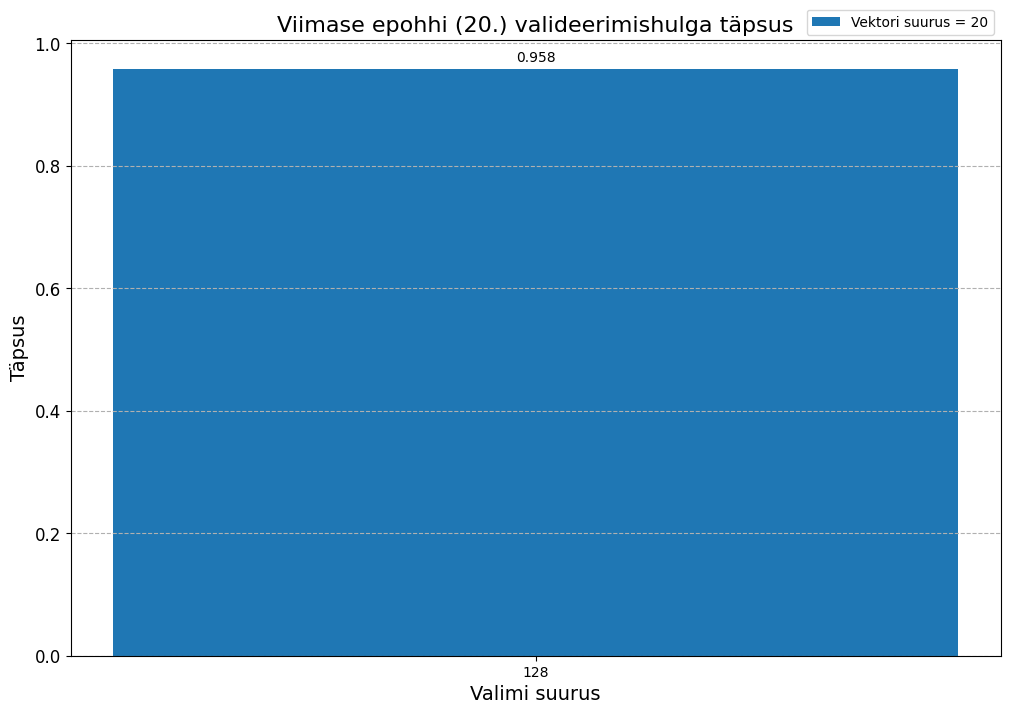

In [ ]:
võrkotsing()

Järgmine funktsioon teostab võrkotsingut leidmaks parima mudeli, mille sisendiks on sõna ja sõnaliik. Parameetrite kombinatsiooni, mida katsetatakse on:
* kihi `Text_vectorization` parameeter `output_sequence_length` ehk `max_pikkused`;
* mudeli treenimise valimite suurused ehk `batch_sizes`;
* LSTM kihi `dropout` ja `recurrent_dropout` parameeter ehk `dropout`;
* epohhide ehk ajasammude arv ehk `epochs`.

In [ ]:
tulemused = list()
def võrkotsing_sõnaliigiga():
  global tulemused, df_algvormidega
  # Parameetrid
  max_pikkused = [20] # 27
  batch_sizes = [128]
  dropout = "0.2"
  #max_pikkused = [20] # 27
  #batch_sizes = [64, 128, 256, 512]
  epochs = 20

  # Stopper
  start_time = time.time()

  # Mõned protsessid saab ühekordselt teha, need ei muutu parameetrite muutmisel
  y, mlb_w = get_y()
  X_s, mlb_s = get_sõnaliigid_üldisem()

  for batch_size in batch_sizes:
    for pikkus in max_pikkused:
      max_pikkus = pikkus # Keskmine sõna pikkus oli ~9.1
      # X kogumine ja varajane eeltöötlus
      X = df_algvormidega['Sõnad']
      X = pd.concat([X, X_s], axis=1)
      # TextVectorization
      tekst_vect = tekst_vect_failid(max_pikkus, X['Sõnad'])
      # Hulkadesse jagamine
      print("Jagan X ja y hulkadesse")
      X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
      X_test, X_val, y_test, y_val = sk.model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
      print("X ja y hulkadesse jaotatud\n")
      # Andmete teisendamine
      print("X hulkade teisendamine")
      X_train_w_vecs = tekst_vect(X_train['Sõnad'])
      X_test_w_vecs = tekst_vect(X_test['Sõnad'])
      X_val_w_vecs = tekst_vect(X_val['Sõnad'])
      X_train_s_vecs = mlb_s.transform(X_train['Üldsõnaliigid'])
      X_test_s_vecs = mlb_s.transform(X_test['Üldsõnaliigid'])
      X_val_s_vecs = mlb_s.transform(X_val['Üldsõnaliigid'])
      #X_train_vecs = tf.keras.utils.pad_sequences(X_train_vecs, maxlen=max_pikkus)
      #X_test_vecs = tf.keras.utils.pad_sequences(X_test_vecs, maxlen=max_pikkus)
      #X_val_vecs = tf.keras.utils.pad_sequences(X_val_vecs, maxlen=max_pikkus)
      print("X hulgad teisendatud\n")
      print("y hulkade teisendamine")
      y_train_vecs = mlb_w.transform(y_train)
      y_test_vecs = mlb_w.transform(y_test)
      y_val_vecs = mlb_w.transform(y_val)
      print("y hulgad teisendatud\n")
      print_lõppseis_sõnaliigiga(X, X_train,
                               X_train_w_vecs, X_test_w_vecs, X_val_w_vecs,
                               X_train_s_vecs, X_test_s_vecs, X_val_s_vecs,
                               y, y_train,
                               y_train_vecs, y_test_vecs, y_val_vecs,
                               mlb_w, mlb_s)
      # Mudeli koostamine
      mudel, callbacks = mudel_init_sõnaliigiga(max_pikkus, mlb_w, mlb_s, tekst_vect, dropout)
      # Mudeli treenimine
      hist = mudel.fit(
                      x=[X_train_w_vecs, X_train_s_vecs],
                      y=y_train_vecs,
                      validation_data=([X_val_w_vecs, X_val_s_vecs], y_val_vecs),
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=callbacks
                      )
      tulemused.append(hist.history)
      print(f"Mudel textVectorizer pikkusega {max_pikkus} ja batch_size suurusega {batch_size} treenitud")
      mudel.save(f"mudel_dropout_{dropout}_batch_size_{batch_size}_multiLSTM_max_pikkus_{max_pikkus}_epochs_{epochs}.keras")
      print(f"Mudel textVectorizer pikkusega {max_pikkus} ja batch_size suurusega {batch_size} salvestatud\n\n")
      print("Testhulgal mudeli hindamine")
      hinnang = mudel.evaluate([X_test_w_vecs, X_test_s_vecs], y_test_vecs)
      print("Testhulgal oli täpsus {0}%, kaofunktsiooni väärtus {1}.\n".format(round(100*hinnang[1], 5),round(hinnang[0],6)))
  save_tulemused(tulemused, max_pikkused, batch_sizes, epochs, "sõnajasõnaliiküldine", dropout)
  näita_tulemusi_tulp(tulemused, max_pikkused, batch_sizes, epochs, "sõnajasõnaliiküldinemudel", dropout)
  print("--- %.3f seconds ---" % (time.time() - start_time))
  # VM lahti ühendamine
  print("Ühendan virtuaalmasina lahti")
  runtime.unassign()

y andmete kogumine
y andmed kogutud

MultiLabelBinarizer kohandamine
MultiLabelBinarizer kohandatud

X andmete (sõnaliigid) kogumine ja ümbertöötlemine
X andmed (sõnaliigid) kogutud ja ümbertöödeldud
MultiLabelBinarizer kohandamine
MultiLabelBinarizer kohandatud

Olemasoleva TextVectorization otsimine
Olemasolev TextVectorization leitud
TextVectorization käes/kohandatud

Jagan X ja y hulkadesse
X ja y hulkadesse jaotatud

X hulkade teisendamine
X hulgad teisendatud

y hulkade teisendamine
y hulgad teisendatud

X teisendus

Kokku: 2240515
Treeninghulk: 1792412 : 1792412
Testhulk: 224051 : 224051
Valideerimishulk: 224052 : 224052
X teisendamta


,Sõnad,Üldsõnaliigid
92197,arvutamisil,n
1053271,maksideks,n
1968929,tõenäoliseilt,n
1971579,tõmbamises,n
1859109,teenindasid,v


X teisendatud


<tf.Tensor: shape=(5, 20), dtype=int64, numpy=
array([[ 3, 11, 15,  8,  6,  3, 14,  4,  5,  4,  7,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [14,  3,  9,  5,  4, 12,  2,  9,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 6, 21,  2, 10, 20, 13,  7,  4,  5,  2,  4,  7,  6,  0,  0,  0,
         0,  0,  0,  0],
       [ 6, 21, 14, 22,  3, 14,  4,  5,  2,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 6,  2,  2, 10,  4, 10, 12,  3,  5,  4, 12,  0,  0,  0,  0,  0,
         0,  0,  0,  0]])>

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]])


y teisendus

Kokku: 2240515
Treeninghulk: 1792412
Testhulk: 224051
Valideerimishulk: 224052
y teisendamata


92197      [['12']]
1053271    [['16']]
1968929    [['10']]
1971579    [['12']]
1859109    [['27']]
Name: Muuttüübid, dtype: object

y teisendatud


array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]])

Muuttüüpide klassid: ["['-']" "['0']" "['1']" "['10', '12']" "['10']" "['11', '9']" "['11']"
 "['12', '10']" "['12']" "['13']" "['14']" "['15']" "['16']" "['17']"
 "['18']" "['19', '2']" "['19']" "['2']" "['20']" "['21']" "['22']"
 "['23', '22']" "['23']" "['24']" "['25']" "['26']" "['27']"
 "['28', '27']" "['28']" "['29']" "['3', '5']" "['3']" "['30']"
 "['31', '27']" "['31']" "['32']" "['33']" "['34']" "['35']" "['36']"
 "['37']" "['38']" "['4']" "['5', '7']" "['5']" "['6']" "['7']" "['8']"
 "['9']"]
49 klassi

Sõnaliikide klassid: ['n' 'u' 'v']
3 klassi

Mudeli ülesehitamine
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sõna (InputLayer)           [(None, 20)]                 0         []                            
                                                                                                  
 sõn

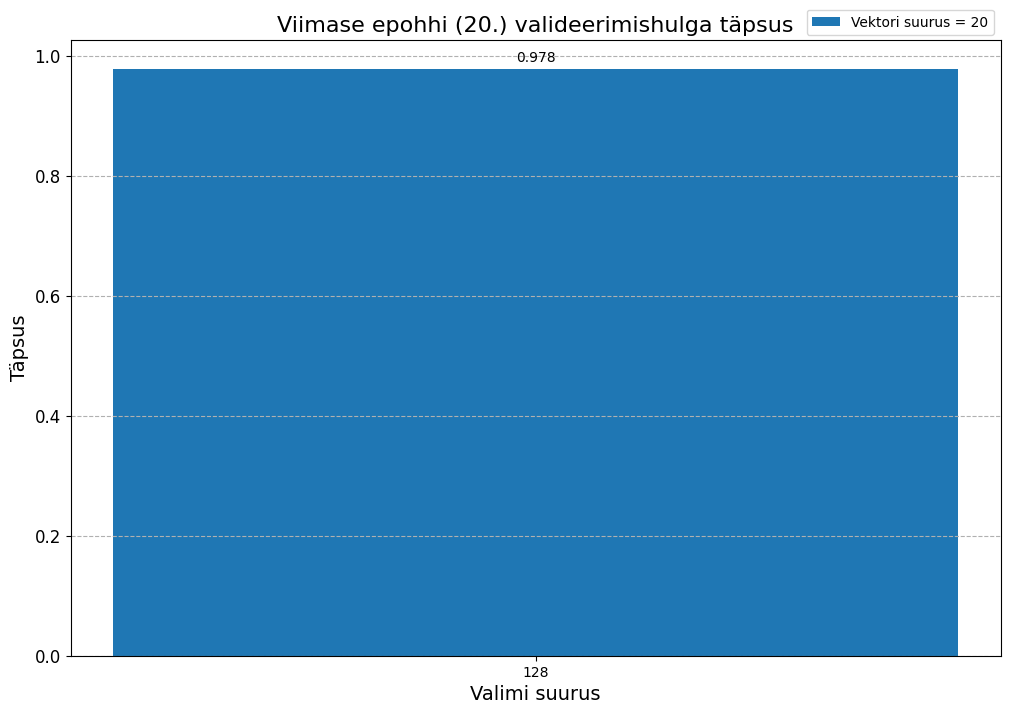

--- 1853.191 seconds ---
Ühendan virtuaalmasina lahti


In [ ]:
võrkotsing_sõnaliigiga()

Järgmine kood on tulemuste ülevaatamiseks ning jooniste valmistamiseks.

In [ ]:
faili_nimi = "history_sõna_max_pikkused_5-25_batch_size_128_epochs_5.npy"
tulemused = loe_tulemused(faili_nimi)
mudel = "sõna"
max_pikkused = [20] # 27
batch_sizes = [64, 128, 256, 512]
#max_pikkused = [5, 10, 15, 20, 25] # 27
#batch_sizes = [128]
dropout = "0"
epochs = 5

match mudel:
  case "sõna":
    save_tulemused(tulemused, max_pikkused, batch_sizes, epochs, "sõna", dropout)
    näita_tulemusi_tulp(tulemused, max_pikkused, batch_sizes, epochs, "sõnamudel", dropout)
  case "sõnajasõnaliik":
    save_tulemused(tulemused, max_pikkused, batch_sizes, epochs, "sõnajasõnaliik", dropout)
    näita_tulemusi_tulp(tulemused, max_pikkused, batch_sizes, epochs, "sõnajasõnaliikmudel", dropout)

### Mudeli hindamine

Selles peatükis hinnatakse mudelit. Uuritakse, kui täpselt suudab mudel igat muuttüüpi ennustada, kui täpselt ennustatakse muuttüüpe igas sõnaliigis ja kui hästi ennustab mudel muuttüüpe algvormidele ja teistele sõnavormidele.

#### Uus

##### Tulemuste kuvamine

In [ ]:
def hindamistulemused(file_path, tulemused, tunnus):
  if tunnus == 'Sõnaliik':
    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
  else:
    fig, ax = plt.subplots(figsize=(8, 12), layout='constrained')
  tunnused = [pos for pos, _, _, _, in tulemused]
  täpsused = [täpsus for _, _, _, täpsus in tulemused]
  kaod = [loss for _, _, loss, _ in tulemused]

  y_pos = np.arange(len(tunnused))

  rects = ax.barh(y_pos, täpsused, align='center')
  ax.set_yticks(y_pos, labels=tunnused)
  ax.invert_yaxis() # Tunnused ülevalt alla
  ax.set_xlabel('Täpsus')
  if tunnus == 'Sõnaliik':
    ax.set_ylabel('Sõnaliikide tähistused')
    ax.set_title('Mudeli täpsus sõnaliigiti')
  else:
    ax.set_ylabel('Muuttüüpide tähistused')
    ax.set_title('Mudeli täpsus muuttüübiti')
  ax.bar_label(rects, padding=3, fmt='%.3f')
  ax.margins(0.1, 0.02)
  plt.show()
  fig.savefig(file_path, format='pdf')
  print(f"Graaf salvestatud faili {file_path}")

In [ ]:
def hindamistulemusedsorteeritud(file_path, tulemused, tunnus):
  file_path += '_järjestatud'
  if tunnus == 'Sõnaliik':
    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
  else:
    fig, ax = plt.subplots(figsize=(8, 12), layout='constrained')
  tulemused_sorted = sorted(tulemused, key=lambda x: x[3], reverse=True)
  tunnused = [pos for pos, _, _, _, in tulemused_sorted]
  täpsused = [täpsus for _, _, _, täpsus in tulemused_sorted]
  kaod = [loss for _, _, loss, _ in tulemused_sorted]

  y_pos = np.arange(len(tunnused))

  rects = ax.barh(y_pos, täpsused, align='center')
  ax.set_yticks(y_pos, labels=tunnused)
  ax.invert_yaxis() # Tunnused ülevalt alla
  ax.set_xlabel('Täpsus')
  if tunnus == 'Sõnaliik':
    ax.set_ylabel('Sõnaliikide tähistused')
    ax.set_title('Mudeli täpsus sõnaliigiti')
  else:
    ax.set_ylabel('Muuttüüpide tähistused')
    ax.set_title('Mudeli täpsus muuttüübiti')
  ax.bar_label(rects, padding=3, fmt='%.3f')
  ax.margins(0.1, 0.02)
  plt.show()
  fig.savefig(file_path, format='pdf')
  print(f"Graaf salvestatud faili {file_path}")

##### Sõnaliigiti hindamine

In [ ]:
def hinda_sõnaliigi_kaupa_sõnamudel(mudeli_path):
  global df_algvormidega

  tulemused_sõnaliigiti = list()

  mudel = tf.keras.models.load_model(mudeli_path)
  mudel.summary()

  max_pikkus = 20 # Keskmine sõna pikkus oli ~12

  # y kogumine ja esmane eeltöötlus
  y, mlb_w = get_y()
  # X kogumine
  X = df_algvormidega[['Sõnad', 'Sõnaliigid']]
  # TextVectorization
  tekst_vect = tekst_vect_failid(max_pikkus, X['Sõnad'])
  # Hulkadesse jagamine
  print("Jagan X ja y hulkadesse")
  X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_test, X_val, y_test, y_val = sk.model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
  print("X ja y hulkadesse jaotatud\n")
  # X ja y andmete ühendamine vastava sõnaliigi kirjete eraldamiseks
  print("Ühendan X ja y andmed")
  y_test_pd = pd.DataFrame(y_test, columns=['Muuttüübid'])
  Xy_test = pd.concat([X_test, y_test_pd], axis=1)
  print("X ja y andmed ühendatud\n")
  for pos in pos_to_group:
    # Vastava sõnaliigi andmete kogumine testhulgast
    print("Testandmete kogumine")
    testandmed = Xy_test[Xy_test['Sõnaliigid'] == pos]
    print("Testandmed kogutud\n")
    if testandmed.empty:
      print(f"Andmed puuduvad sõnaliigi {pos} jaoks")
      continue
    # Andmete teisendamine
    print("X hulk teisendamine")
    X_test_vecs = tekst_vect(testandmed['Sõnad'])
    print("X hulk teisendatud\n")
    print("y hulk teisendamine")
    y_test_vecs = mlb_w.transform(testandmed['Muuttüübid'])
    print("y hulk teisendatud\n")
    loss, accuracy = mudel.evaluate(X_test_vecs, y_test_vecs)
    tulemused_sõnaliigiti.append((pos, len(testandmed), loss, accuracy))
    print(f"Sõnaliik {pos}")
    print(f"Ridu: {len(testandmed)}")
    print(f"Test kadu: {loss}")
    print(f"Test täpsus: {accuracy}")

  print("Tulemuste väljastamine sõnaliigiti:")
  for pos, ridu, loss, accuracy in tulemused_sõnaliigiti:
    print(f"Sõnaliik {pos}")
    print(f"Ridu: {ridu}")
    print(f"Test kadu: {loss}")
    print(f"Test täpsus: {accuracy}")

  return tulemused_sõnaliigiti

In [ ]:
mudeli_path = 'Models/sõnamudel_dropout_0.0_batch_size_128_LSTM_max_pikkus_20_epochs_20.keras'
#mudeli_path = 'Models/mudel_dropout_0.0_batch_size_128_LSTM_max_pikkus_20_epochs_20.keras' vana
tulemused_sõnaliigiti = hinda_sõnaliigi_kaupa_sõnamudel(mudeli_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 49)            3283      
                                                                 
 lstm_1 (LSTM)               (None, 160)               134400    
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 49)                7889      
                                                                 
Total params: 145572 (568.64 KB)
Trainable params: 145572 (568.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
y andmete kogumine
y andmed kogutud

MultiLabelBinarizer kohandamine
MultiLabelBinarizer kohandatud

Olemasoleva TextVectorization otsimine
Olemas

Tulemused salvestatud faili sõnamudeli_hindamistulemused_sõnaliigiti


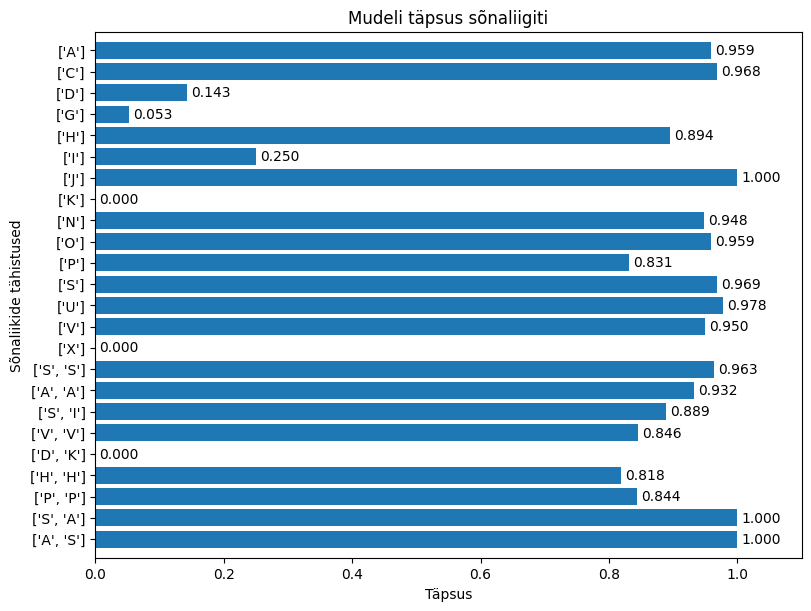

Graaf salvestatud faili sõnamudeli_hindamistulemused_sõnaliigiti


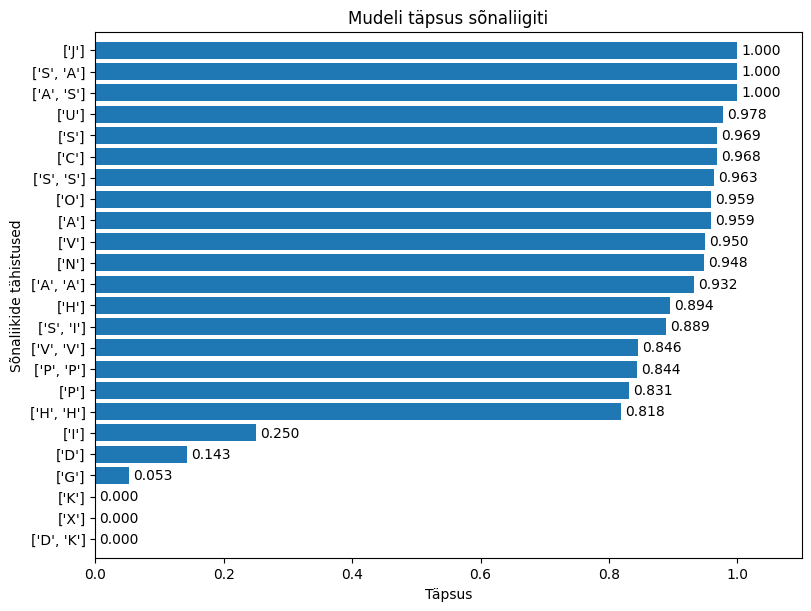

Graaf salvestatud faili sõnamudeli_hindamistulemused_sõnaliigiti_järjestatud


In [ ]:
file_path = "sõnamudeli_hindamistulemused_sõnaliigiti"
np.save(file_path, tulemused_sõnaliigiti)
print(f"Tulemused salvestatud faili {file_path}")
hindamistulemused(file_path, tulemused_sõnaliigiti, 'Sõnaliik')
hindamistulemusedsorteeritud(file_path, tulemused_sõnaliigiti, 'Sõnaliik')

In [ ]:
def hinda_sõnaliigi_kaupa_sõna_ja_sõnaliigi_mudel(mudeli_path):
  global df_algvormidega

  tulemused_sõnaliigiti = list()

  mudel = tf.keras.models.load_model(mudeli_path)
  mudel.summary()

  max_pikkus = 20 # Keskmine sõna pikkus oli ~12

  # y kogumine ja esmane eeltöötlus
  y, mlb_w = get_y()
  # X kogumine
  X_s, mlb_s = get_sõnaliigid_üldisem()
  X = df_algvormidega[['Sõnad', 'Sõnaliigid']]
  X = pd.concat([X, X_s], axis=1)
  # TextVectorization
  tekst_vect = tekst_vect_failid(max_pikkus, X['Sõnad'])
  # Hulkadesse jagamine
  print("Jagan X ja y hulkadesse")
  X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_test, X_val, y_test, y_val = sk.model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
  print("X ja y hulkadesse jaotatud\n")
  # X ja y andmete ühendamine vastava sõnaliigi kirjete eraldamiseks
  print("Ühendan X ja y andmed")
  y_test_pd = pd.DataFrame(y_test, columns=['Muuttüübid'])
  Xy_test = pd.concat([X_test, y_test_pd], axis=1)
  print("X ja y andmed ühendatud\n")
  for pos in pos_to_group:
    # Vastava sõnaliigi andmete kogumine testhulgast
    print("Testandmete kogumine")
    testandmed = Xy_test[Xy_test['Sõnaliigid'] == pos]
    print("Testandmed kogutud\n")
    if testandmed.empty:
      print(f"Andmed puuduvad sõnaliigi {pos} jaoks")
      continue
    # Andmete teisendamine
    print("X hulk teisendamine")
    X_test_w_vecs = tekst_vect(testandmed['Sõnad'])
    X_test_s_vecs = mlb_s.transform(testandmed['Üldsõnaliigid'])
    print("X hulk teisendatud\n")
    print("y hulk teisendamine")
    y_test_vecs = mlb_w.transform(testandmed['Muuttüübid'])
    print("y hulk teisendatud\n")
    loss, accuracy = mudel.evaluate([X_test_w_vecs, X_test_s_vecs], y_test_vecs)
    tulemused_sõnaliigiti.append((pos, len(testandmed), loss, accuracy))
    print(f"Sõnaliik {pos}")
    print(f"Ridu: {len(testandmed)}")
    print(f"Test kadu: {loss}")
    print(f"Test täpsus: {accuracy}")

  print("Tulemuste väljastamine sõnaliigiti:")
  for pos, ridu, loss, accuracy in tulemused_sõnaliigiti:
    print(f"Sõnaliik {pos}")
    print(f"Ridu: {ridu}")
    print(f"Test kadu: {loss}")
    print(f"Test täpsus: {accuracy}")

  return tulemused_sõnaliigiti

In [ ]:
mudeli_path = 'Models/sõnamudel_sõnaliigiga_dropout_0.2_batch_size_128_multiLSTM_max_pikkus_20_epochs_20.keras'
#mudeli_path = 'Models/mudel_dropout_0.0_batch_size_128_multiLSTM_max_pikkus_20_epochs_20.keras' vana
tulemused_sõnaliigiti = hinda_sõnaliigi_kaupa_sõna_ja_sõnaliigi_mudel(mudeli_path)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sõna (InputLayer)           [(None, 20)]                 0         []                            
                                                                                                  
 sõnaliik (InputLayer)       [(None, 3)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 20, 49)               3283      ['sõna[0][0]']                
                                                                                                  
 embedding_1 (Embedding)     (None, 3, 49)                147       ['sõnaliik[0][0]']            
                                                                                              

Tulemused salvestatud faili sõnajasõnaliigimudeli_hindamistulemused_sõnaliigiti


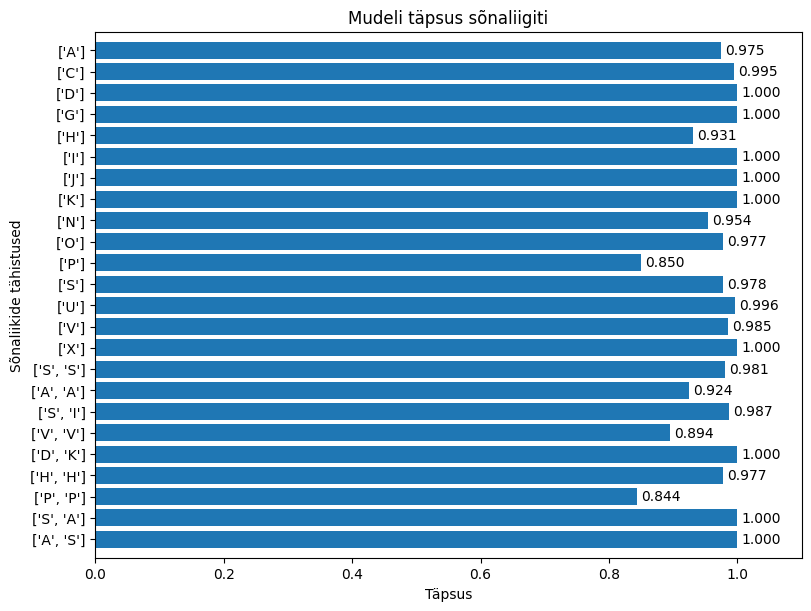

Graaf salvestatud faili sõnajasõnaliigimudeli_hindamistulemused_sõnaliigiti


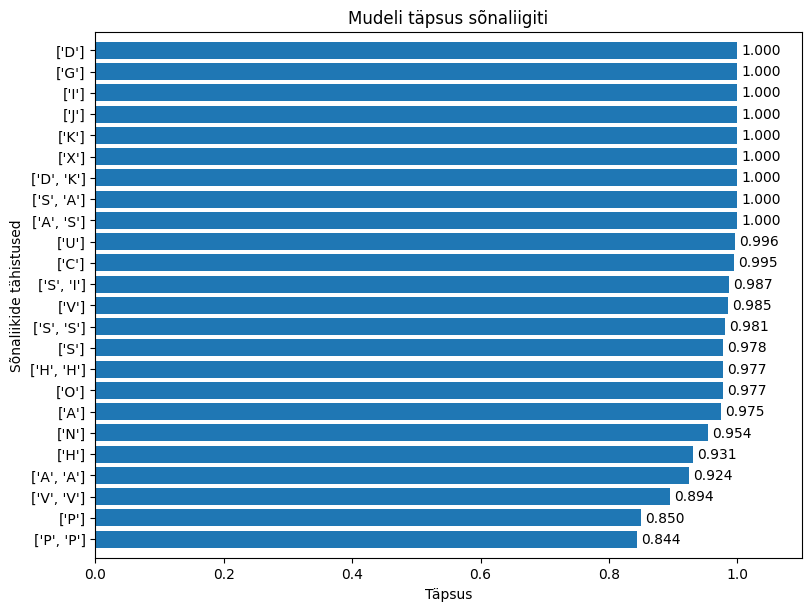

Graaf salvestatud faili sõnajasõnaliigimudeli_hindamistulemused_sõnaliigiti_järjestatud


In [ ]:
file_path = "sõnajasõnaliigimudeli_hindamistulemused_sõnaliigiti"
np.save(file_path, tulemused_sõnaliigiti)
print(f"Tulemused salvestatud faili {file_path}")
hindamistulemused(file_path, tulemused_sõnaliigiti, 'Sõnaliik')
hindamistulemusedsorteeritud(file_path, tulemused_sõnaliigiti, 'Sõnaliik')

##### Muuttüübiti hindamine

In [ ]:
mt_to_group = ["['-']", "['0']", "['1']", "['10', '12']", "['10']", "['11', '9']", "['11']", "['12', '10']",
              "['12']", "['13']", "['14']", "['15']", "['16']", "['17']", "['18']", "['19', '2']", "['19']",
              "['2']", "['20']", "['21']", "['22']", "['23', '22']", "['23']", "['24']", "['25']", "['26']",
              "['27']", "['28', '27']", "['28']", "['29']", "['3', '5']", "['3']", "['30']", "['31', '27']",
              "['31']", "['32']", "['33']", "['34']", "['35']", "['36']", "['37']", "['38']", "['4']",
              "['5', '7']", "['5']", "['6']", "['7']", "['8']", "['9']"] # Kõik muuttüübid andmestikus

In [ ]:
def hinda_muuttüübi_kaupa_sõnamudel(mudeli_path):
  global df_algvormidega, tulemused_muuttüübiti

  tulemused_muuttüübiti = list()

  mudel = tf.keras.models.load_model(mudeli_path)
  mudel.summary()

  max_pikkus = 20 # Keskmine sõna pikkus oli ~12

  # y kogumine ja esmane eeltöötlus
  y, mlb_w = get_y()
  # X kogumine
  X = df_algvormidega['Sõnad']
  # TextVectorization
  tekst_vect = tekst_vect_failid(max_pikkus, X)
  # Hulkadesse jagamine
  print("Jagan X ja y hulkadesse")
  X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_test, X_val, y_test, y_val = sk.model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
  print("X ja y hulkadesse jaotatud\n")
  # X ja y andmete ühendamine vastava muuttüübi kirjete eraldamiseks
  print("Ühendan X ja y andmed")
  y_test_pd = pd.DataFrame(y_test.apply(lambda x: x[0]), columns=['Muuttüübid']) # Listi eemaldamine
  Xy_test = pd.concat([X_test, y_test_pd], axis=1)
  print("X ja y andmed ühendatud\n")
  for mt in mt_to_group:
    # Vastava muuttüübi andmete kogumine testhulgast
    print("Testandmete kogumine")
    testandmed = Xy_test[Xy_test['Muuttüübid'] == mt]
    print("Testandmed kogutud\n")
    if testandmed.empty:
      print(f"Andmed puuduvad muuttüübi {mt} jaoks")
      continue
    # Andmete teisendamine
    y_test = testandmed['Muuttüübid'].apply(lambda x: [x]) # Listi tagasi
    print("X hulk teisendamine")
    X_test_vecs = tekst_vect(testandmed['Sõnad'])
    print("X hulk teisendatud\n")
    print("y hulk teisendamine")
    y_test_vecs = mlb_w.transform(y_test)
    print("y hulk teisendatud\n")
    loss, accuracy = mudel.evaluate(X_test_vecs, y_test_vecs)
    tulemused_muuttüübiti.append((mt, len(testandmed), loss, accuracy))
    print(f"Muuttüüp {mt}")
    print(f"Ridu: {len(testandmed)}")
    print(f"Test kadu: {loss}")
    print(f"Test täpsus: {accuracy}")

  print("Tulemuste väljastamine muuttüübiti:")
  for mt, ridu, loss, accuracy in tulemused_muuttüübiti:
    print(f"Muuttüüp {mt}")
    print(f"Ridu: {ridu}")
    print(f"Test kadu: {loss}")
    print(f"Test täpsus: {accuracy}")

  return tulemused_muuttüübiti

In [ ]:
mudeli_path = 'Models/sõnamudel_dropout_0.0_batch_size_128_LSTM_max_pikkus_20_epochs_20.keras'
#mudeli_path = 'Models/mudel_dropout_0.0_batch_size_128_LSTM_max_pikkus_20_epochs_20.keras'
tulemused_muuttüübiti = hinda_muuttüübi_kaupa_sõnamudel(mudeli_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 49)            3283      
                                                                 
 lstm_1 (LSTM)               (None, 160)               134400    
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 49)                7889      
                                                                 
Total params: 145572 (568.64 KB)
Trainable params: 145572 (568.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
y andmete kogumine
y andmed kogutud

MultiLabelBinarizer kohandamine
MultiLabelBinarizer kohandatud

Olemasoleva TextVectorization otsimine
Olemas

Tulemused salvestatud faili sõnamudeli_hindamistulemused_muuttüübiti


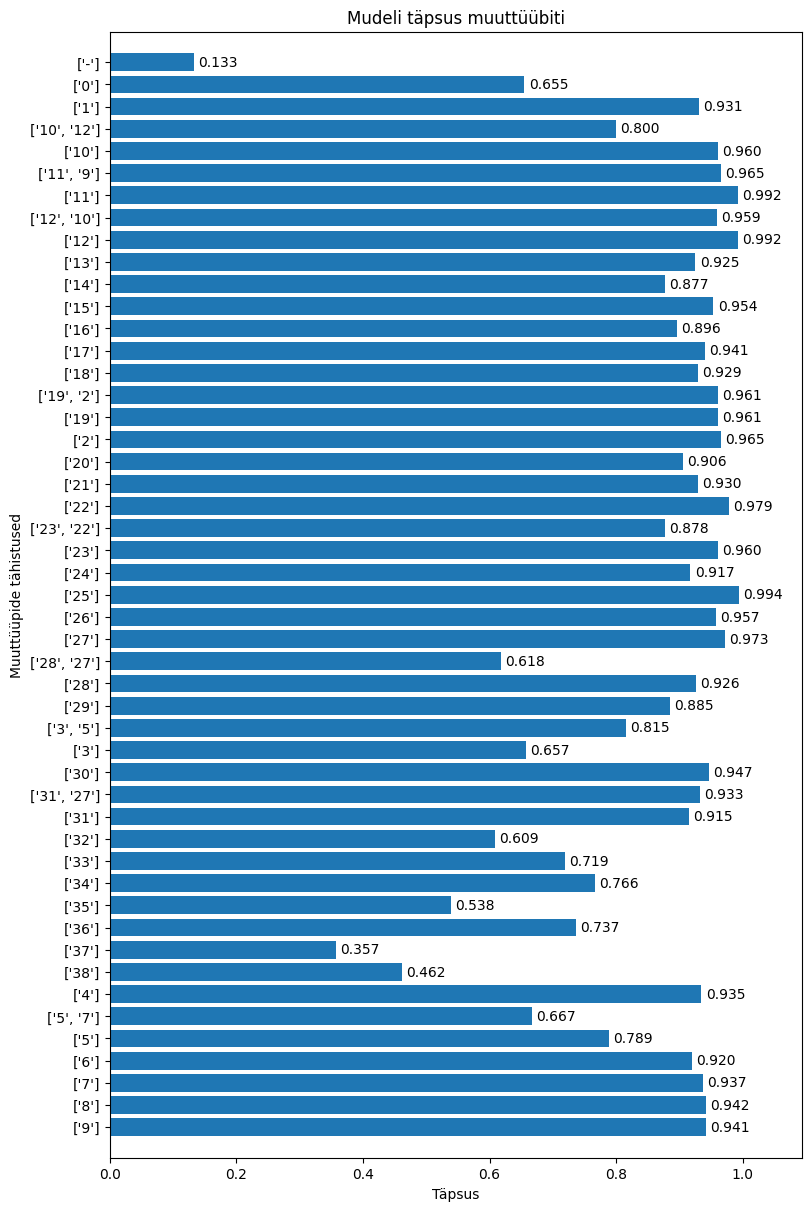

Graaf salvestatud faili sõnamudeli_hindamistulemused_muuttüübiti


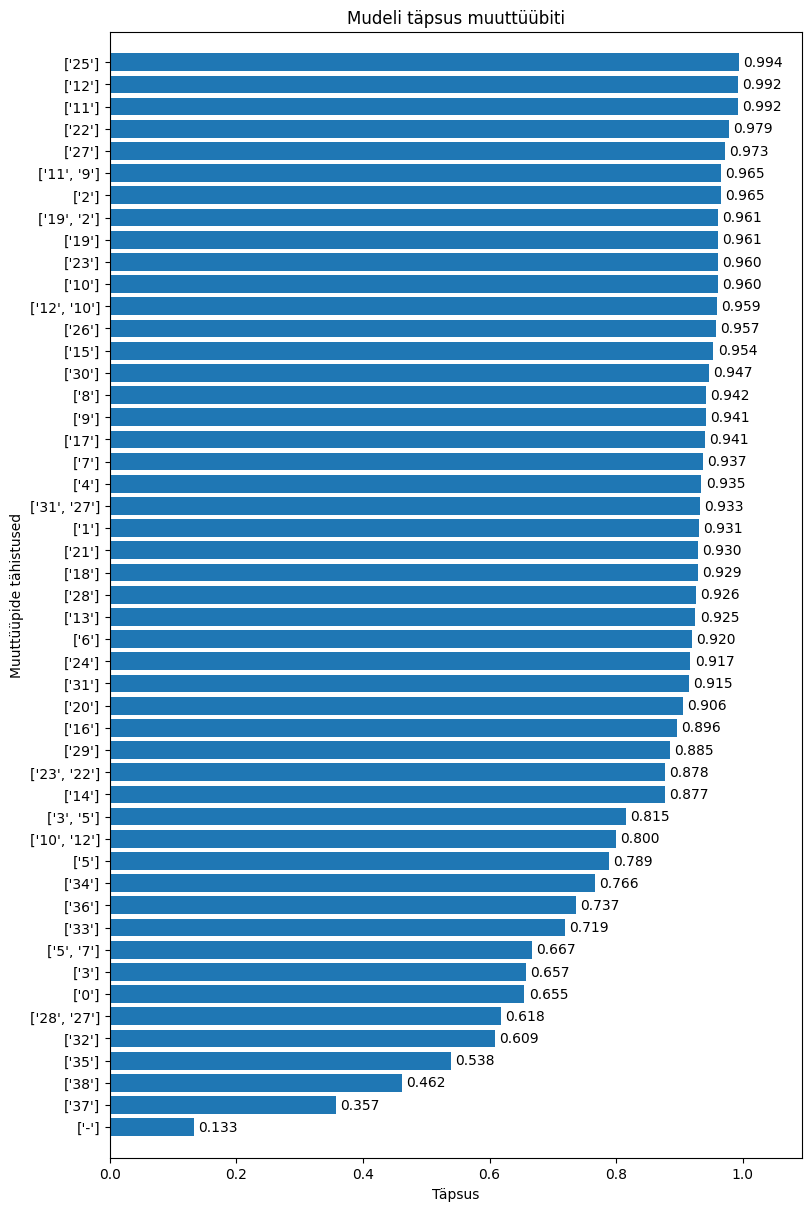

Graaf salvestatud faili sõnamudeli_hindamistulemused_muuttüübiti_järjestatud


In [ ]:
file_path = "sõnamudeli_hindamistulemused_muuttüübiti"
np.save(file_path, tulemused_muuttüübiti)
print(f"Tulemused salvestatud faili {file_path}")
hindamistulemused(file_path, tulemused_muuttüübiti, 'Muuttüüp')
hindamistulemusedsorteeritud(file_path, tulemused_muuttüübiti, 'Muuttüüp')

In [ ]:
def hinda_muuttüübi_kaupa_sõna_ja_sõnaliigi_mudel(mudeli_path):
  global df_algvormidega

  tulemused_muuttüübiti = list()

  mudel = tf.keras.models.load_model(mudeli_path)
  mudel.summary()

  max_pikkus = 20 # Keskmine sõna pikkus oli ~12

  # y kogumine ja esmane eeltöötlus
  y, mlb_w = get_y()
  # X kogumine
  X_s, mlb_s = get_sõnaliigid_üldisem()
  X = df_algvormidega['Sõnad']
  X = pd.concat([X, X_s], axis=1)
  # TextVectorization
  tekst_vect = tekst_vect_failid(max_pikkus, X['Sõnad'])
  # Hulkadesse jagamine
  print("Jagan X ja y hulkadesse")
  X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_test, X_val, y_test, y_val = sk.model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
  print("X ja y hulkadesse jaotatud\n")
  # X ja y andmete ühendamine vastava muuttüübi kirjete eraldamiseks
  print("Ühendan X ja y andmed")
  y_test_pd = pd.DataFrame(y_test.apply(lambda x: x[0]), columns=['Muuttüübid']) # Listi eemaldamine
  Xy_test = pd.concat([X_test, y_test_pd], axis=1)
  print("X ja y andmed ühendatud\n")
  for mt in mt_to_group:
    # Vastava muuttüübi andmete kogumine testhulgast
    print("Testandmete kogumine")
    testandmed = Xy_test[Xy_test['Muuttüübid'] == mt]
    print("Testandmed kogutud\n")
    if testandmed.empty:
      print(f"Andmed puuduvad muuttüübi {mt} jaoks")
      continue
    # Andmete teisendamine
    y_test = testandmed['Muuttüübid'].apply(lambda x: [x]) # Listi tagasi
    print("X hulk teisendamine")
    X_test_w_vecs = tekst_vect(testandmed['Sõnad'])
    X_test_s_vecs = mlb_s.transform(testandmed['Üldsõnaliigid'])
    print("X hulk teisendatud\n")
    print("y hulk teisendamine")
    y_test_vecs = mlb_w.transform(y_test)
    print("y hulk teisendatud\n")
    loss, accuracy = mudel.evaluate([X_test_w_vecs, X_test_s_vecs], y_test_vecs)
    tulemused_muuttüübiti.append((mt, len(testandmed), loss, accuracy))
    print(f"Sõnaliik {mt}")
    print(f"Ridu: {len(testandmed)}")
    print(f"Test kadu: {loss}")
    print(f"Test täpsus: {accuracy}")

  print("Tulemuste väljastamine muuttüübiti:")
  for mt, ridu, loss, accuracy in tulemused_muuttüübiti:
    print(f"Sõnaliik {mt}")
    print(f"Ridu: {ridu}")
    print(f"Test kadu: {loss}")
    print(f"Test täpsus: {accuracy}")

  return tulemused_muuttüübiti

In [ ]:
mudeli_path = 'Models/sõnamudel_sõnaliigiga_dropout_0.2_batch_size_128_multiLSTM_max_pikkus_20_epochs_20.keras'
#mudeli_path = 'Models/mudel_dropout_0.0_batch_size_128_multiLSTM_max_pikkus_20_epochs_20.keras'
tulemused_muuttüübiti = hinda_muuttüübi_kaupa_sõna_ja_sõnaliigi_mudel(mudeli_path)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sõna (InputLayer)           [(None, 20)]                 0         []                            
                                                                                                  
 sõnaliik (InputLayer)       [(None, 3)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 20, 49)               3283      ['sõna[0][0]']                
                                                                                                  
 embedding_1 (Embedding)     (None, 3, 49)                147       ['sõnaliik[0][0]']            
                                                                                              

Tulemused salvestatud faili sõnajasõnaliigimudeli_hindamistulemused_muuttüübiti


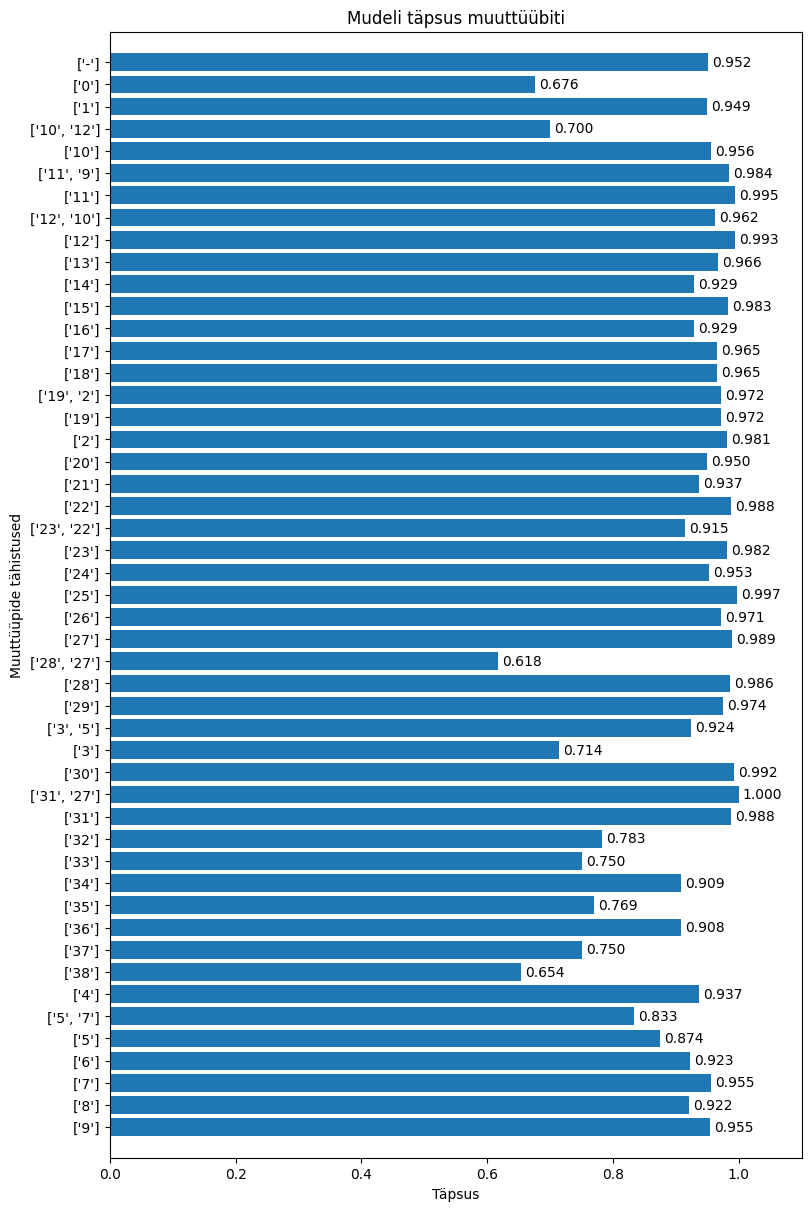

Graaf salvestatud faili sõnajasõnaliigimudeli_hindamistulemused_muuttüübiti


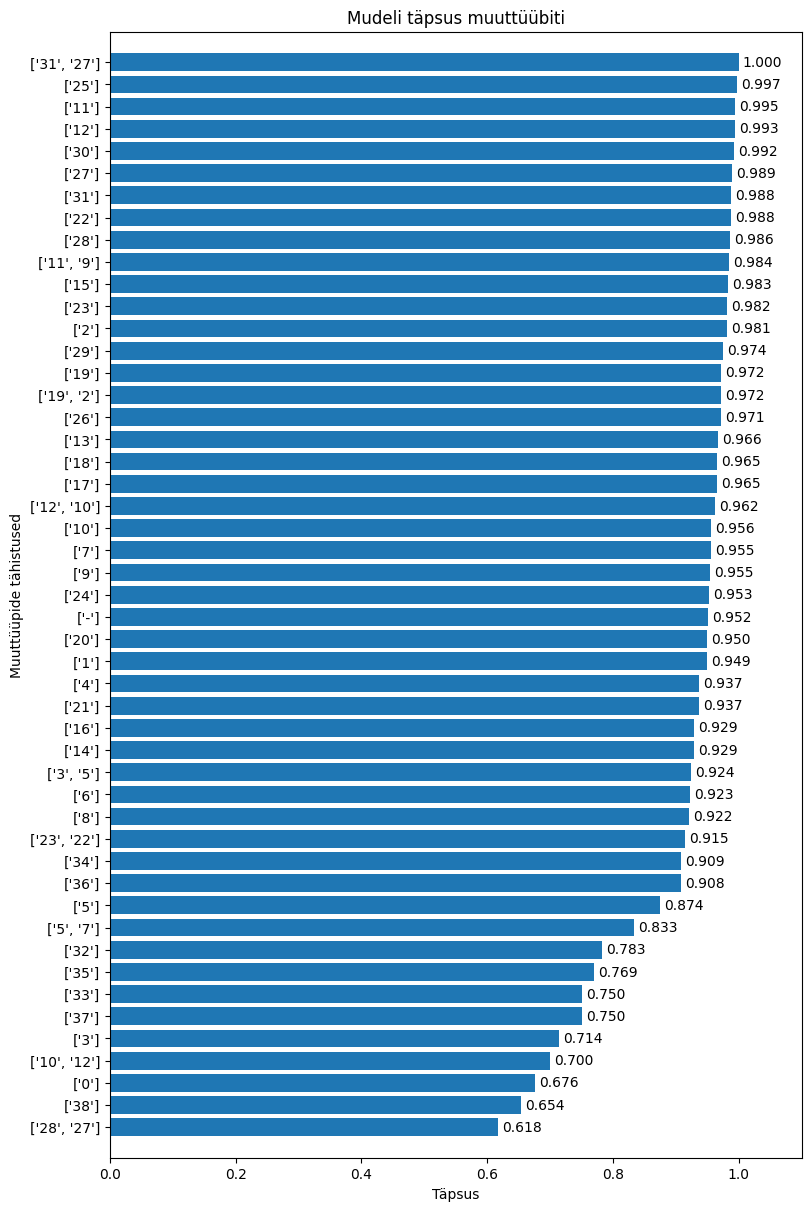

Graaf salvestatud faili sõnajasõnaliigimudeli_hindamistulemused_muuttüübiti_järjestatud


In [ ]:
file_path = "sõnajasõnaliigimudeli_hindamistulemused_muuttüübiti"
np.save(file_path, tulemused_muuttüübiti)
print(f"Tulemused salvestatud faili {file_path}")
hindamistulemused(file_path, tulemused_muuttüübiti, 'Muuttüüp')
hindamistulemusedsorteeritud(file_path, tulemused_muuttüübiti, 'Muuttüüp')

##### Algvormi ja teiste sõnavormide hindamine

In [ ]:
def hinda_algvormide_kaupa_sõnamudel(mudeli_path):
  global df_algvormidega

  tulemused_algvormiti = list()

  mudel = tf.keras.models.load_model(mudeli_path)
  mudel.summary()

  max_pikkus = 20 # Keskmine sõna pikkus oli ~12

  # y kogumine ja esmane eeltöötlus
  y, mlb_w = get_y()
  # X kogumine
  X = df_algvormidega[['Sõnad', 'Algvormid']]
  # TextVectorization
  tekst_vect = tekst_vect_failid(max_pikkus, X)
  # Hulkadesse jagamine
  print("Jagan X ja y hulkadesse")
  X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_test, X_val, y_test, y_val = sk.model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
  print("X ja y hulkadesse jaotatud\n")
  # X ja y andmete ühendamine algvormi
  print("Ühendan X ja y andmed")
  y_test_pd = pd.DataFrame(y_test.apply(lambda x: x[0]), columns=['Muuttüübid']) # Listi eemaldamine
  Xy_test = pd.concat([X_test, y_test_pd], axis=1)
  print("X ja y andmed ühendatud\n")
  for tüüp in ['algvormid', 'muud']:
    if tüüp == 'algvormid':
      print("Testandmete kogumine")
      testandmed = Xy_test[Xy_test['Sõnad'] == Xy_test['Algvormid']]
      print("Testandmed kogutud\n")
    else:
      print("Testandmete kogumine")
      testandmed = Xy_test[Xy_test['Sõnad'] != Xy_test['Algvormid']]
      print("Testandmed kogutud\n")
    if testandmed.empty:
      print(f"Andmed puuduvad")
      return None
    # Andmete teisendamine
    y_test = testandmed['Muuttüübid'].apply(lambda x: [x]) # Listi tagasi
    print("X hulk teisendamine")
    X_test_vecs = tekst_vect(testandmed['Sõnad'])
    print("X hulk teisendatud\n")
    print("y hulk teisendamine")
    y_test_vecs = mlb_w.transform(y_test)
    print("y hulk teisendatud\n")
    loss, accuracy = mudel.evaluate(X_test_vecs, y_test_vecs)
    tulemused_algvormiti.append((len(testandmed), loss, accuracy))
    print(f"Ridu: {len(testandmed)}")
    print(f"Test kadu: {loss}")
    print(f"Test täpsus: {accuracy}")

  print("Tulemuste väljastamine algvormi ja muude sõnavormide kaupa:")
  for ridu, loss, accuracy in tulemused_algvormiti:
    print(f"Ridu: {ridu}")
    print(f"Test kadu: {loss}")
    print(f"Test täpsus: {accuracy}")

  return tulemused_algvormiti

In [ ]:
mudeli_path = 'Models/sõnamudel_dropout_0.0_batch_size_128_LSTM_max_pikkus_20_epochs_20.keras'
#mudeli_path = 'Models/mudel_dropout_0.0_batch_size_128_LSTM_max_pikkus_20_epochs_20.keras'
tulemused_muuttüübiti = hinda_algvormide_kaupa_sõnamudel(mudeli_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 49)            3283      
                                                                 
 lstm_1 (LSTM)               (None, 160)               134400    
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 49)                7889      
                                                                 
Total params: 145572 (568.64 KB)
Trainable params: 145572 (568.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
y andmete kogumine
y andmed kogutud

MultiLabelBinarizer kohandamine
MultiLabelBinarizer kohandatud

Olemasoleva TextVectorization otsimine
Olemas

In [ ]:
def hinda_algvormide_kaupa_sõna_ja_sõnaliigi_mudel(mudeli_path):
  global df_algvormidega

  tulemused_algvormiti = list()

  mudel = tf.keras.models.load_model(mudeli_path)
  mudel.summary()

  max_pikkus = 20 # Keskmine sõna pikkus oli ~12

  # y kogumine ja esmane eeltöötlus
  y, mlb_w = get_y()
  # X kogumine
  X_s, mlb_s = get_sõnaliigid_üldisem()
  X = df_algvormidega[['Sõnad', 'Algvormid']]
  X = pd.concat([X, X_s], axis=1)
  # TextVectorization
  tekst_vect = tekst_vect_failid(max_pikkus, X['Sõnad'])
  # Hulkadesse jagamine
  print("Jagan X ja y hulkadesse")
  X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_test, X_val, y_test, y_val = sk.model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
  print("X ja y hulkadesse jaotatud\n")
  # X ja y andmete ühendamine vastava sõnaliigi kirjete eraldamiseks
  print("Ühendan X ja y andmed")
  y_test_pd = pd.DataFrame(y_test.apply(lambda x: x[0]), columns=['Muuttüübid']) # Listi eemaldamine
  Xy_test = pd.concat([X_test, y_test_pd], axis=1)
  print("X ja y andmed ühendatud\n")
  for tüüp in ['algvormid', 'muud']:
    if tüüp == 'algvormid':
      print("Testandmete kogumine")
      testandmed = Xy_test[Xy_test['Sõnad'] == Xy_test['Algvormid']]
      print("Testandmed kogutud\n")
    else:
      print("Testandmete kogumine")
      testandmed = Xy_test[Xy_test['Sõnad'] != Xy_test['Algvormid']]
      print("Testandmed kogutud\n")
    if testandmed.empty:
      print(f"Andmed puuduvad")
      return None
    # Andmete teisendamine
    y_test = testandmed['Muuttüübid'].apply(lambda x: [x]) # Listi tagasi
    print("X hulk teisendamine")
    X_test_w_vecs = tekst_vect(testandmed['Sõnad'])
    X_test_s_vecs = mlb_s.transform(testandmed['Üldsõnaliigid'])
    print("X hulk teisendatud\n")
    print("y hulk teisendamine")
    y_test_vecs = mlb_w.transform(y_test)
    print("y hulk teisendatud\n")
    loss, accuracy = mudel.evaluate([X_test_w_vecs, X_test_s_vecs], y_test_vecs)
    tulemused_algvormiti.append((len(testandmed), loss, accuracy))
    print(f"Ridu: {len(testandmed)}")
    print(f"Test kadu: {loss}")
    print(f"Test täpsus: {accuracy}")

  print("Tulemuste väljastamine algvormi ja muude sõnavormide kaupa:")
  for ridu, loss, accuracy in tulemused_algvormiti:
    print(f"Ridu: {ridu}")
    print(f"Test kadu: {loss}")
    print(f"Test täpsus: {accuracy}")

  return tulemused_algvormiti

In [ ]:
mudeli_path = 'Models/sõnamudel_sõnaliigiga_dropout_0.2_batch_size_128_multiLSTM_max_pikkus_20_epochs_20.keras'
#mudeli_path = 'Models/mudel_dropout_0.0_batch_size_128_multiLSTM_max_pikkus_20_epochs_20.keras'
tulemused_muuttüübiti = hinda_algvormide_kaupa_sõna_ja_sõnaliigi_mudel(mudeli_path)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sõna (InputLayer)           [(None, 20)]                 0         []                            
                                                                                                  
 sõnaliik (InputLayer)       [(None, 3)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 20, 49)               3283      ['sõna[0][0]']                
                                                                                                  
 embedding_1 (Embedding)     (None, 3, 49)                147       ['sõnaliik[0][0]']            
                                                                                              

### Ennustamine

Selles peatükis on võimalik kasutada mudelit muuttüüpide ennustamiseks sõnadele.

Järgmise koodiga võetakse häälestatud muuttüübi `MultiLabelBinarizer`. Eeldatakse, et fail on kättesaadav kaustas `Binarizers` failinimena `mlb_w.pkl`.

In [5]:
def get_mlb_w(df_algvormidega):
  filename = 'Binarizers/mlb_w.pkl'
  if os.path.exists(filename):
    with open(filename, 'rb') as file:
      mlb_w = pickle.load(file)
  else:
    y = df_algvormidega['Muuttüübid'].apply(lambda x: [x]) # lambda x: [x] arvestab rööptüüpidega
    mlb_w = sk.preprocessing.MultiLabelBinarizer()
    mlb_w.fit(y)
    with open(filename, 'wb') as file:
      pickle.dump(mlb_w, file)
  return mlb_w

Järgmise koodiga võetakse häälestatud üldisema sõnaliigi `MultiLabelBinarizer`. Eeldatakse, et fail on kättesaadav kaustas `Binarizers` failinimena `mlb_s.pkl`.

In [6]:
def get_mlb_s_üldisem(df_algvormidega):
  pos_to_group = {
        "['A']": 'n',  # omadussõna - algvõrre (adjektiiv - positiiv), nii käänduvad kui käändumatud, nt kallis või eht, Adjective
        "['C']": 'n',  # omadussõna - keskvõrre (adjektiiv - komparatiiv), nt laiem, Comparative adjective
        "['D']": 'u',  # määrsõna (adverb), nt kõrvuti, Adverb
        "['G']": 'u',  # genitiivatribuut (käändumatu omadussõna), nt balti, Genitive attribute
        "['H']": 'n',  # pärisnimi, nt Edgar, Proper noun
        "['I']": 'u',  # hüüdsõna (interjektsioon), nt tere, Interjection
        "['J']": 'u',  # sidesõna (konjunktsioon), nt ja, Conjunction
        "['K']": 'u',  # kaassõna (pre/postpositsioon), nt kaudu, Pre/postposition
        "['N']": 'n',  # põhiarvsõna (kardinaalnumeraal), nt kaks, Cardinal numeral
        "['O']": 'n',  # järgarvsõna (ordinaalnumeraal), nt teine, Ordinal numeral
        "['P']": 'n',  # asesõna (pronoomen), nt see, Pronoun
        "['S']": 'n',  # nimisõna (substantiiv), nt asi, Noun
        "['U']": 'n',  # omadussõna - ülivõrre (adjektiiv - superlatiiv), nt pikim, Superlative adjective
        "['V']": 'v',  # tegusõna (verb), nt lugema, Verb
        "['X']": 'u',  # verbi juurde kuuluv sõna, millel eraldi sõnaliigi tähistus puudub, nt plehku, Adverb-like word used solely with a certain verb
        "['Y']": 'n',  # lühend, nt USA, Abbreviation or acronym
        "['Z']": 'u',  # lausemärk, nt -, /, ..., Punctuation
        # Siit alates lisaks statistikast leitud read
        "['S', 'S']": 'n',
        "['A', 'A']": 'n',
        "['S', 'I']": 'n',
        "['V', 'V']": 'v',
        "['D', 'K']": 'u',
        "['H', 'H']": 'n',
        "['P', 'P']": 'n',
        "['S', 'A']": 'n',
        "['K', 'D']": 'u',
        "['A', 'S']": 'n',
    }

  filename = 'Binarizers/mlb_s.pkl'

  if os.path.exists(filename):
    with open(filename, 'rb') as file:
      mlb_s = pickle.load(file)
  else:
    X_s_grouped = df_algvormidega['Sõnaliigid'].apply(lambda x: pos_to_group.get(x, 'u'))
    mlb_s = sk.preprocessing.MultiLabelBinarizer()
    mlb_s.fit(X_s_grouped)
    with open(filename, 'wb') as file:
      pickle.dump(mlb_s, file)
  return mlb_s

Järgmise koodiga võetakse häälestatud sõnade TextVectorization. Eeldatakse, et failid on kättesaadavad kaustas `TextVectorizations` nimedena `text_vectorization_len_20_model_architecture.pkl` ja `text_vectorization_len_20_vocab.pkl`

In [7]:
def tekst_vect_failid():
  # Kaust, kuhu on kogutud kõik TextVectorization'id
  kaust = "./TextVectorizations/"

  # Tekst_vect failide asukohad
  architecture_file = kaust + "text_vectorization_len_20_model_architecture.pkl"
  vocab_file = kaust + "text_vectorization_len_20_vocab.pkl"

  # Kui on olemas failid, siis loe sisse
  if os.path.exists(architecture_file) and os.path.exists(vocab_file):
    with open(architecture_file, "rb") as f:
        model_config = pickle.load(f)
    with open(vocab_file, "rb") as f:
        vocab = pickle.load(f)

    tekst_vect = tf.keras.layers.TextVectorization.from_config(model_config)
    tekst_vect.set_vocabulary(vocab)
  else:
    print("Ei leidnud olemasolevat TextVectorization.")
    return None

  return tekst_vect

Järgmine kood on funktsioon muuttüüpide ennustamiseks.

Sõnamudeli kasutamiseks eeldatakse sisendiks järjendit sõnadest  kujul `[sõna_1, sõna_2, ...]`.

Sõnamudel sõnaliigiga kasutamiseks eeldatakse sisendiks järjendit sõnadest  kujul `[sõna_1, sõna_2, ...]` ja järjendit sõnaliikidest kujul `[sõnaliik_1, sõnaliik_2, ...]`.

In [46]:
def leia_muuttüüp(sõna, sõnaliik = ''):

  df_algvormidega = pd.read_csv("andmed_algvormidega.csv", header=0, keep_default_na=False)

  # Mudeli leidmine
  try:
    if sõnaliik: # Sõnaliigiga sõnamudel
      mudeli_path = 'Models/sõnamudel_sõnaliigiga_dropout_0.2_batch_size_128_multiLSTM_max_pikkus_20_epochs_20.keras'
    else: # Sõnamudel
      mudeli_path = 'Models/sõnamudel_dropout_0.0_batch_size_128_LSTM_max_pikkus_20_epochs_20.keras'
    mudel = tf.keras.models.load_model(mudeli_path)
  except OSError as e:
    print(f"{mudeli_path} ei ole mudel")
    return

  # TextVectorization
  tekst_vect = tekst_vect_failid()
  if not tekst_vect:
    return
  X_w = tekst_vect(sõna)

  # Muuttüübid
  mlb_w = get_mlb_w(df_algvormidega)
  if sõnaliik:
    # Sõnaliigid
    mlb_s = get_mlb_s_üldisem(df_algvormidega)
    sõnaliik = [[s] for s in sõnaliik]
    X_s = mlb_s.transform(sõnaliik)

  # Ennustamine
  if sõnaliik:
    sisend_tulemused = mudel([X_w, X_s], training=False)
  else:
    sisend_tulemused = mudel(X_w, training=False)

  # Tulemuste salvestamine
  tulemused = list()
  for tulemus in sisend_tulemused:
    indeks = np.argmax(tulemus)
    ennustatud_muuttüüp = mlb_w.classes_[indeks]
    ennustatud_muuttüüp = re.sub(r"[\[\]']", "", ennustatud_muuttüüp)#.split(',')
    # Teisendab muuttüübi andmetüübi täisarvuks
    #if len(ennustatud_muuttüüp) > 1:
    #  ennustatud_muuttüüp = [int(ennustatud_muuttüüp[0]), int(ennustatud_muuttüüp[1])]
    #else:
    #  ennustatud_muuttüüp = [int(ennustatud_muuttüüp[0])]
    tulemused.append(ennustatud_muuttüüp)

  return tulemused

Järgnev kood kasutab sõnamudelit muuttüübi ennustamiseks.

In [37]:
leia_muuttüüp(["vilistlasel", "sinist", "musta", "ja", "valget", "ülikoolis", "arukalt"])

['12', '10', '22', '-', '6', '22', '2']

Järgnev kood kasutab sõnamudelit sõnaliigiga muuttüübi ennustamiseks.

In [ ]:
leia_muuttüüp(["vilistlasel", "sinist", "musta", "ja", "valget", "ülikoolis", "arukalt"], ['n', 'n', 'n', 'u', 'n', 'n', 'u'])

1/1 [==============================] - 1s 759ms/step


['12', '10', '22', '-', '1', '22', '-']

In [41]:
leia_muuttüüp(["sulgema", "sulen", "sulgen", "sule", "sulge", "sulgeda"])

['28, 27', '28', '27', '22', '22', '28, 27']